# Project - Day 3 - Computer Vision and Image Analysis with Deep Learning techniques

## Introduction

During the first two days of the school, you have learned to acquire data and process them.
In this notebook we will focus, instead, on the statistical analysis you can perform on data. 
This is often a crucial step to distill information from the original dataset, and is often sufficiently computing-intensive to make data management techniques discussed in this school critical to the success of the analysis.

In [1]:
learning_rate = 1e-3
batch_size = 10
n_epochs = 50

In [2]:
# Parameters
n_epochs = 120
learning_rate = 0.001
batch_size = 32


## Recap

This is a set of simulated data that people tried hard to make as similar as possible to the acquired data, though minor differences might appear.
You should use it to traing your model and to ensure your model is not overfitting. 

You may also try to measure the performance of the model, but remember this is not real data.


In [3]:
%%bash

## Download the training dataset from an INFN archive
wget https://pandora.infn.it/public/269d22/dl/training_set.zip -qO $HOME/data/training_set.zip

## Install the unzip utility 
#apt-get -qy install unzip

## Extract the archive
cd $HOME/data/
unzip -qn $HOME/data/training_set.zip

As in the previous notebooks, you can list all the files obtained from the unzipped archive globbing `data/data/export/*/*/*/*.png`.

In [4]:
from glob import glob
filenames = glob("/home/jovyan/data/data/export/*/*/*/*.png")
print (f"Found {len(filenames)} filenames")

Found 612 filenames


## Preprocessing steps ⚙️⚙️⚙️

The preprocessing steps were discussed during the previous days, here we are just copy-pasting the functions discussed there 📋.

In particular you have here the implementations of:
 * `load_image`, which is `dask.delayed` wrapper around PIL and numpy to load an image as numpy array
 * `load_raw_images`, which loads all the images from a list of file names passed as argument and returns a dask array with stacked images
 * `windowing`, which maps the pixel values from the interval [0, 255] to [0, 1] while clipping the extreme values (below 60 and above 130)
 * `crop_center`, which crops the center of the image where the signal is located, returning a square with side 128 pixels.

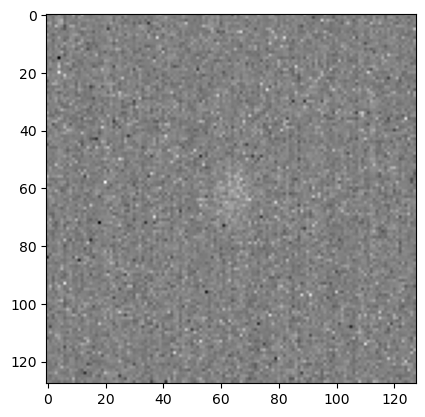

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import dask, dask.array

## See Day 2
@dask.delayed 
def load_image(filename: str):
    """Wrapper function loading image as a dask.delayed"""
    return np.asarray(Image.open(filename))

## See Day 2
def load_raw_images(filenames):
    """Load the images from the file paths in `filenames` into a delayed dask-array"""
    return dask.array.stack([
        dask.array.from_delayed(load_image(f), shape=(576, 576), dtype=np.uint8) 
        for f in filenames
    ], axis=0)


## Discussed in Day 1, implemented in Day 2
def windowing(dask_image, x_min, x_max):
    """Maps the pixel values from the interval [x_min, x_max] to [0, 1]"""
    return dask.array.clip((dask_image - x_min)/(x_max - x_min), 0., 1.)

## Discussed in Day 1, implemented in Day 2
def crop_center(dask_image, half_win=64):
    """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
    low, high = 576//2 - half_win, 576//2 + half_win
    return dask_image[:,low:high, low:high]

preprocessed = crop_center(windowing(load_raw_images(filenames), 60, 130))
plt.imshow(preprocessed[0].compute(), cmap='gray')
plt.show()

## Retrieving information from the image path 🖍️
As discussed while moving the first steps with the dataset (day 1), we can retrieve information on the energy and on the event type.

In notebook 1, we solved it with plain Python, here it is done (in one line) with regular expressions, which seems nice, but beware of following quote from [Jamie Zawinski](https://blog.codinghorror.com/regular-expressions-now-you-have-two-problems/#:~:text=If%20you've%20ever%20talked,hacker%20who%20I%20admire%20greatly.)  😁😁😁:
 > Some people, when confronted with a problem,
 > think *"I know, I'll use regular expressions."*
 >
 > Now they have two problems.


In [6]:
import re
def energy_keV_from_path(filenames):
    """
    Return a dask array with the energy (in keV) as obtained parsing a sequence of filenames passed 
    as an argument.
    """
    return dask.array.from_array([float(re.findall(r"/([0-9]+)_keV", f)[0]) for f in filenames])

def is_nuclear_from_path(filenames):
    """
    Return an array of boolean, true for nuclear recoil, or false for electron recoils as 
    obtained parsing the list of filenames passed as an argument.
    """
    return dask.array.from_array([float('NR' in re.findall(r"/([NE]R)/", f)) for f in filenames])

## Exercise 1 - Preparation of the training 🏋️ and validation 🕵️ datasets

Because of the functioning of glob, the filenames obtained above are ordered. 
If you split them without shuffling, you end up with a validation set which is not representative of the training set.
On the same line, if you split the training dataset in batches without shuffling, subsequent batches will be very different from each other generating large gradients in the loss function and making the training procedure unstable.

For this reason, you should **shuffle** your list of filenames before doing anything else.

Check the [docs of `numpy.random.permutation`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) to shuffle your globbed list of file names.

In [7]:
shuffled_filenames = np.random.permutation(filenames)

print(filenames[:5])
print(shuffled_filenames[:5])

['/home/jovyan/data/data/export/train/NR/3_keV/cygno-0002.png', '/home/jovyan/data/data/export/train/NR/3_keV/cygno-0001.png', '/home/jovyan/data/data/export/train/NR/20_keV/cygno-0064.png', '/home/jovyan/data/data/export/train/NR/20_keV/cygno-0017.png', '/home/jovyan/data/data/export/train/NR/20_keV/cygno-0063.png']
['/home/jovyan/data/data/export/train/ER/3_keV/cygno-0038.png'
 '/home/jovyan/data/data/export/train/ER/3_keV/cygno-0082.png'
 '/home/jovyan/data/data/export/train/NR/6_keV/cygno-0080.png'
 '/home/jovyan/data/data/export/train/NR/20_keV/cygno-0016.png'
 '/home/jovyan/data/data/export/train/ER/3_keV/cygno-0090.png']


### 🔀 Split the list of shuffled dataset 

Pick **50 entries** from the shuffled list of filenames (for example the first 50) and reserve them for validation.

The remaining entries will be used to load your training dataset.

In [8]:
training_files = shuffled_filenames[50:]
validation_files = shuffled_filenames[:50]

### Apply the preprocessing steps 
Apply the functions `windowing` and `crop_center` to the `training_files` and the `validation_files`, to create the dask-delayed training and validation sets.

Similarly, apply the functions `is_nuclear_from_path` and `energy_keV_from_path` to define the *labels* and the *energy* associated to each filename.

The next code cell should look like
```python
training_set = ...
validation_set = ...

training_label = ...
validation_label = ...

training_energy = ...
validation_energy = ...
```


In [9]:
training_set = crop_center(windowing(load_raw_images(training_files), 60, 130))
validation_set = crop_center(windowing(load_raw_images(validation_files), 60, 130))

training_label = is_nuclear_from_path(training_files)
validation_label = is_nuclear_from_path(validation_files)

training_energy = energy_keV_from_path(training_files)
validation_energy = energy_keV_from_path(validation_files)

In [10]:
training_label

dask.array<array, shape=(562,), dtype=float64, chunksize=(562,), chunktype=numpy.ndarray>

## Exercise 2 - Verify your dataset 🤔

Before moving forward, it is a good idea to cross-check and print some statistics of the training sample. 

Here you can find a couple of histograms obtained by the organizers during the preparation of the exercise. 
You can compare your dataset to them to avoid wasting time training on a ill-defined dataset.

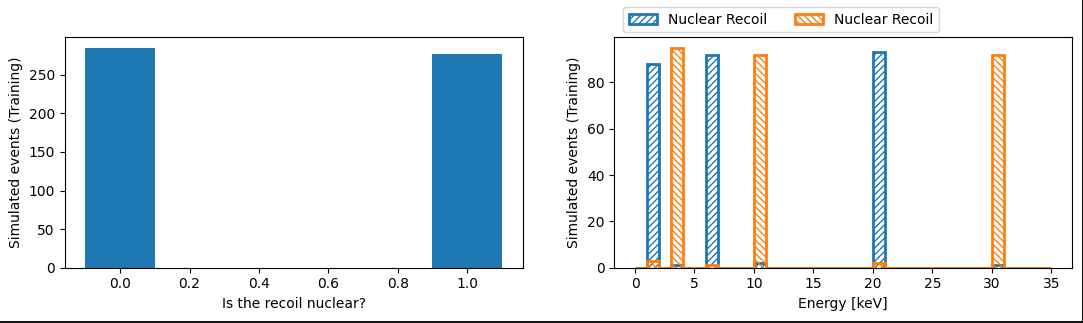

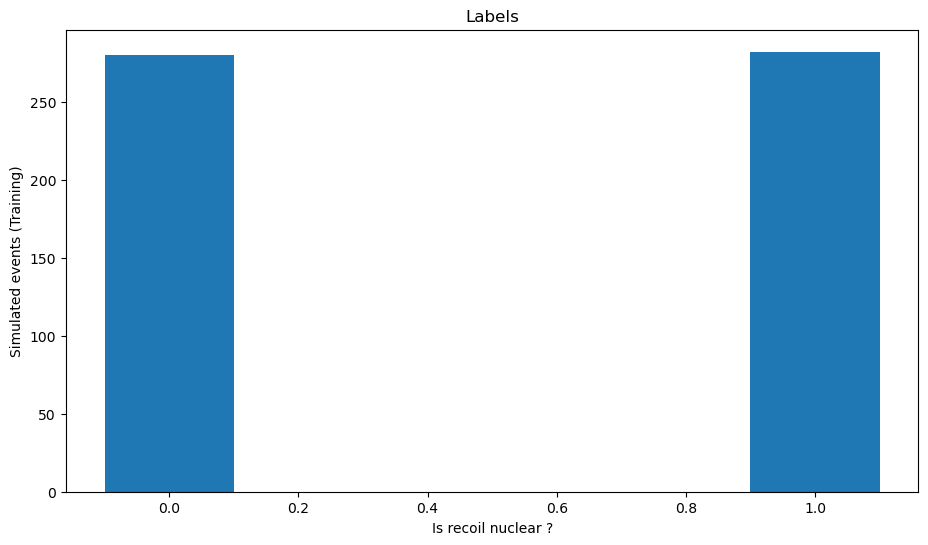

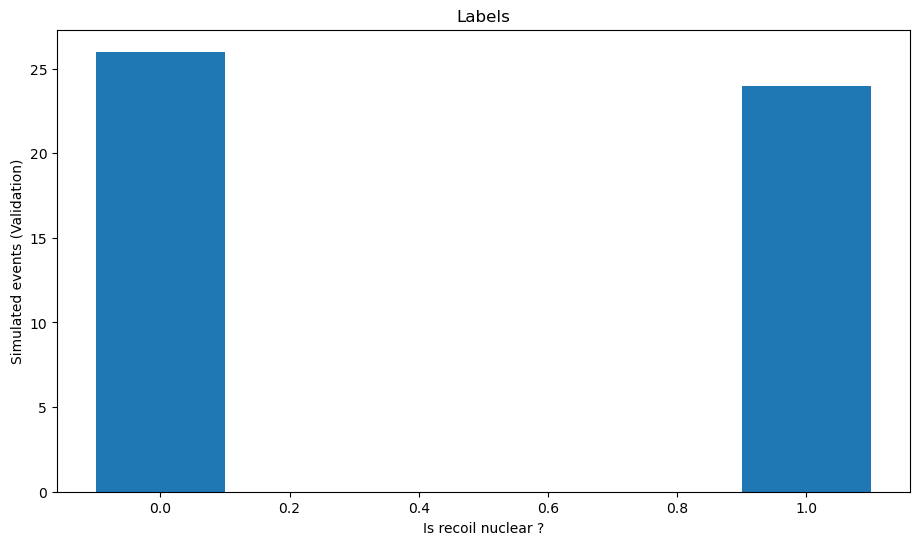

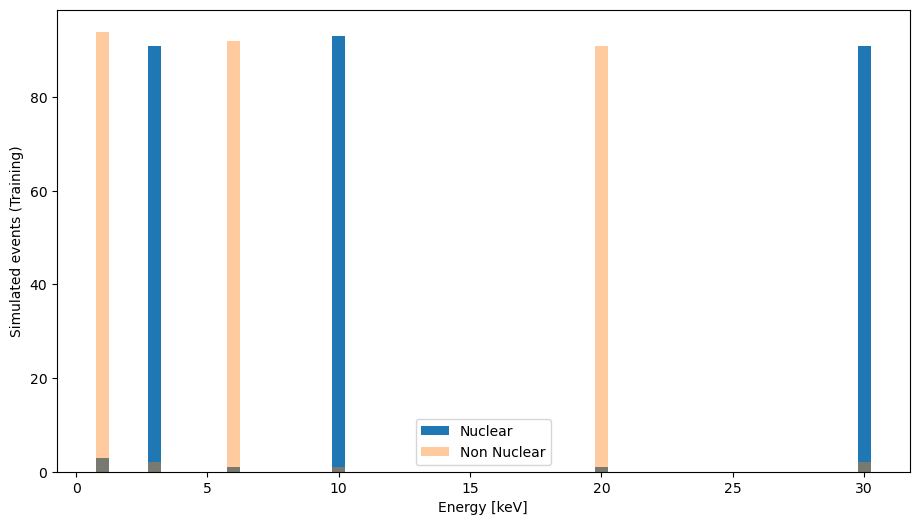

In [11]:
u, count = np.unique(np.array(training_label), return_counts=True)

plt.figure(figsize=(11,6))
plt.bar(u, count, width=.2)
plt.title("Labels")
plt.xlabel("Is recoil nuclear ?")
plt.ylabel("Simulated events (Training)")
plt.show()

u, count = np.unique(np.array(validation_label), return_counts=True)
plt.figure(figsize=(11,6))
plt.bar(u, count, width=.2)
plt.title("Labels")
plt.xlabel("Is recoil nuclear ?")
plt.ylabel("Simulated events (Validation)")
plt.show()

plt.figure(figsize=(11,6))
idx_nuc    = np.where(np.array(training_label) == 0.0, True, False)
idx_nonnuc = np.where(np.array(training_label) == 1.0, True, False)
u, count = np.unique(np.array(training_energy)[idx_nuc], return_counts=True)
plt.bar(u, count, width=.5)
u, count = np.unique(np.array(training_energy)[idx_nonnuc], return_counts=True)
plt.bar(u, count, width=.5, alpha=.4)
plt.legend(['Nuclear', 'Non Nuclear'])
plt.xlabel("Energy [keV]")
plt.ylabel("Simulated events (Training)")
plt.show()

## Exercise 3 - Define your Convolutional Neural Network 🤖🤖🤖

Define a simple CNN for a classification task.

Remember:
 * The input shape of the preprocessed images is (128, 128)
 * The activation function of the last layer should be a `sigmoid` and the loss should be a Binary Crossentropy
 * It might help to use some regularization of the kernel weights to make the training more stable.
 * Don't make it too complex or it will take forever to train, don't make it too simple or it will perform very poorly and you won't find any dark matter 🙃. 

In [12]:
import tensorflow as tf
import tqdm
from tqdm import trange 

2024-12-05 08:33:03.989721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 08:33:04.030815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 08:33:04.030889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 08:33:04.030915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 08:33:04.038285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 08:33:04.039961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

2024-12-05 08:33:04.954856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
## The learning rate defines the leap taken at each update of the weights
# learning_rate = 1e-3

## We create a deep sequential model (layers are executed in a sequence, one after the other)
classifier = tf.keras.models.Sequential([
    ## We reshape the images making it explicit that they have 1 single channel
    tf.keras.layers.Reshape((128, 128, 1), name="reshape"),

    ## First Convolutional block (conv + conv + max pooling)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    ## Second Convolutional block (equal to the previous one)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    # 3 Conv Layers
    #tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    #tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    
    ## Finally, we flatten the generated image and we use the computed channels as input of a 
    ## last dense layer, activated by a sigmoid.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
])

## Before training we may want to specify the input shape of the dataset:
## Batches of any number of elements (None) with each element being a 28x28 matrix
classifier.build(input_shape=(None, 128, 128))

## Then we must assign a loss function and an optimizer to be used 
## for the training.
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate)
)

## Optionally, we can print the model obtained, counting the variables and estimating the 
## storage requirements if we plan to export the model.
display(classifier.summary())

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 reshape (Reshape)           (None, 128, 128, 1)       0         


 conv2d (Conv2D)             (None, 126, 126, 8)       80        


 conv2d_1 (Conv2D)           (None, 124, 124, 8)       584       


 max_pooling2d (MaxPooling2  (None, 62, 62, 8)         0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 60, 60, 8)         584       


 conv2d_3 (Conv2D)           (None, 58, 58, 8)         584       


 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 8)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 6728)              0         


 dense (Dense)               (None, 1)                 6729      


Total params: 8561 (33.44 KB)


Trainable params: 8561 (33.44 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


None

## Exercise 4 - Re-chunk your dask arrays to represent batches of the training procedure

The Deep Learning libraries, such as TensorFlow, are designed to benefit from parallelization muliple ways, and expect a large portion of the dataset to be presented to the neural network at once. This is particularly important for "small data entries", such as rows of a table or small MNIST image, for which looping over the instances in Python would waste most of the computing power, but it is still beneficial for images with 16k pixels. 

At the opposite extreme, if the RAM of your system is smaller than the size of your dataset you have no choice but splitting it into batches and process one batch at once.

There are multiple ways to define batches, but since you are now a major expert of dask, we'll do it with dask! 

Use the [`dask.array.rechunk` function](https://docs.dask.org/en/latest/generated/dask.array.rechunk.html) to customize the size of the chunks.

**It is very important that you are consistent between the chunk structure of the input, image data and of the labels indicating whether the recoil is nuclear or electronic.**

We organizers obtained decent results with batches (or chunks) of 10 images, but you are encouraged to explore what happens using larger or smaller batch sizes. 

The following cell might look like
```python

batch_size = 10

X_train = training_set...
X_valid = validation_set...
y_train = training_label...
y_valid = validation_label...

```

In [14]:
# batch_size = 10

X_train = training_set.rechunk(batch_size)
X_valid = validation_set.rechunk(batch_size)
y_train = training_label.rechunk(batch_size)
y_valid = validation_label.rechunk(batch_size)

In [15]:
X_train

dask.array<rechunk-merge, shape=(562, 128, 128), dtype=float64, chunksize=(32, 32, 32), chunktype=numpy.ndarray>

## Exercise 5 - Train for a single epoch 🏋️

An epoch correspond to a training performed on the whole dataset, possibly iterating over multiple batches. 

To iterate on batches and train your neural network (say `classifier`) on each batch, you can use the following structure.

```bash
for X, y in zip(X_train.blocks, y_train.blocks):
  classifier.train_on_batch(X, y)
```

Depending on the complexity of your network, this loop is expected to take 5 to 15 seconds. If it takes longer, there might be something odd happening in your code.

The evolution of the loss through the epoch should not be too different from the following plot.

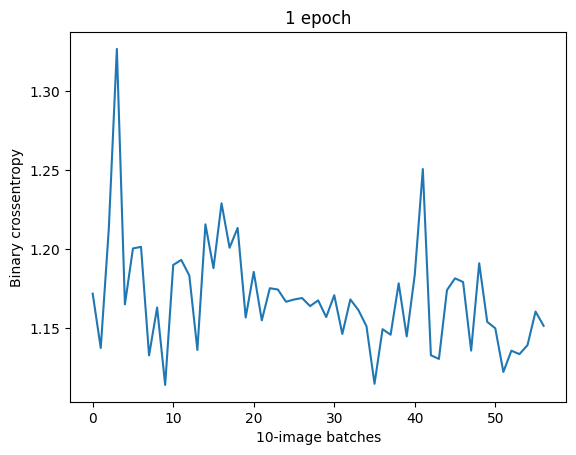

You may want to check:
  * the [docs of `dask.array.blocks`](https://docs.dask.org/en/stable/generated/dask.array.Array.blocks.html#dask-array-array-blocks)
  * the [docs of (keras.Model.train_on_batch)](https://keras.io/api/models/model_training_apis/#trainonbatch-method)

In [16]:
## As above we prepare a list to collect the losses at each step
losses = []
validation_losses = []


## We count the number of blocks of the X_train 
n_blocks = X_train.numblocks[0]

## We prepare a progress bar counting the updates
##  (check https://github.com/tqdm/tqdm for docs on progress bars)
with trange(n_blocks, unit='updates') as progress_bar:
    ## We prepare the inner loop, relying on the function zip looping on "pairs" of iterables
    ##   zip([a, b, c], [1, 2, 3]) --> [a, 1], [b, 2], [c, 3] 
    for image_chunk, label_chunk in zip(X_train.blocks, y_train.blocks):
        progress_bar.update(1)  ## Explicit update of the progress bar

        ## We train on a single batch as defined by dask, and store the output in a list
        loss = classifier.train_on_batch(image_chunk, label_chunk)
        losses.append(loss)

        ## We evaluate the trained model on the validation dataset
        validation_loss = classifier.test_on_batch(X_valid, y_valid)
        validation_losses.append(validation_loss)
    

  0%|                                                                                                                                                                       | 0/18 [00:00<?, ?updates/s]

 11%|█████████████████▋                                                                                                                                             | 2/18 [00:01<00:12,  1.31updates/s]

 17%|██████████████████████████▌                                                                                                                                    | 3/18 [00:01<00:09,  1.63updates/s]

 22%|███████████████████████████████████▎                                                                                                                           | 4/18 [00:02<00:07,  1.94updates/s]

 28%|████████████████████████████████████████████▏                                                                                                                  | 5/18 [00:02<00:06,  2.13updates/s]

 33%|█████████████████████████████████████████████████████                                                                                                          | 6/18 [00:03<00:05,  2.24updates/s]

 39%|█████████████████████████████████████████████████████████████▊                                                                                                 | 7/18 [00:03<00:04,  2.32updates/s]

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 8/18 [00:03<00:04,  2.40updates/s]

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 9/18 [00:04<00:03,  2.45updates/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 10/18 [00:04<00:03,  2.62updates/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 11/18 [00:04<00:02,  2.65updates/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 12/18 [00:05<00:02,  2.66updates/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 13/18 [00:05<00:01,  2.69updates/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 14/18 [00:06<00:01,  2.69updates/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 15/18 [00:06<00:01,  2.75updates/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 16/18 [00:06<00:00,  2.69updates/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 17/18 [00:07<00:00,  2.71updates/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.80updates/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.20updates/s]

Text(0, 0.5, 'Binary Cross-entropy')

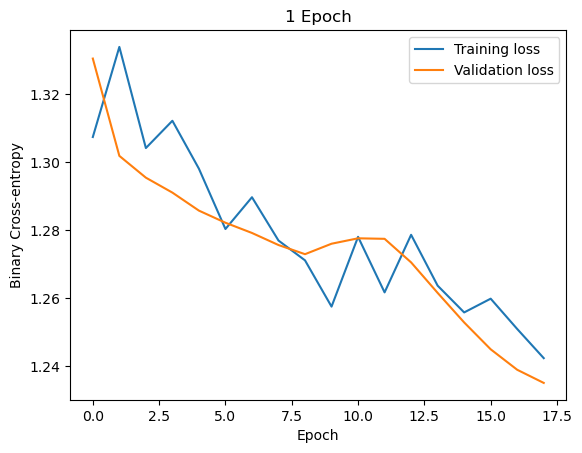

In [17]:
epoch = np.arange(len(losses))/n_blocks
plt.plot(losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title("1 Epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-entropy")

## Exercise 6 - Train for 50 epochs (🏋️$\times 50$)

You have now the building block to repeat the training multiple times, or for multiple epochs. 
Try for example with 50 epochs. 

For each epoch, you may also want to compute the loss on the validation sample to ensure the model is still able to generalize to your 50 images subtracted to the training dataset.

Code structure may look like:
```python
for epoch in range(50):
  for X, y in zip(X_train.blocks, y_train.blocks):
    classifier.train_on_batch(X_train, y_train)
  classifier.test_on_batch(X_valid, y_valid)
```

You should build a plot comparing the evolution of the two losses (on the training and validation dataset) that might resemble to the following one.

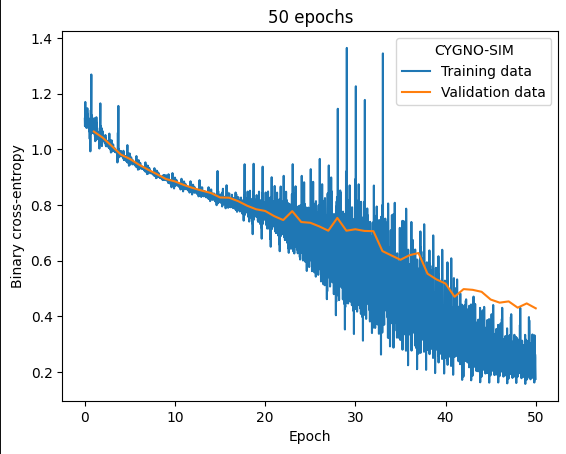

In [18]:
## As above we prepare a list to collect the losses at each step
losses = []
validation_losses = []

# n_epochs = 50
## We count the number of blocks of the X_train 
n_blocks = X_train.numblocks[0]

## We prepare a progress bar counting the updates
##  (check https://github.com/tqdm/tqdm for docs on progress bars)
    ## We prepare the inner loop, relying on the function zip looping on "pairs" of iterables
    ##   zip([a, b, c], [1, 2, 3]) --> [a, 1], [b, 2], [c, 3] 
for epoch in range(n_epochs):
    epoch_losses = []
    with trange(n_blocks, unit='updates', desc=f"Epoch {epoch+1}", position=0, leave=False) as progress_bar:
        for image_chunk, label_chunk in zip(X_train.blocks, y_train.blocks):
            progress_bar.update(1)  ## Explicit update of the progress bar
    
            ## We train on a single batch as defined by dask, and store the output in a list
            loss = classifier.train_on_batch(image_chunk, label_chunk)
            epoch_losses.append(loss)

        losses.append(np.mean(epoch_losses))
        
        ## We evaluate the trained model on the validation dataset
        validation_loss = classifier.test_on_batch(X_valid, y_valid)
        validation_losses.append(validation_loss)
    

Epoch 1:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 1:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  8.72updates/s]

Epoch 1:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:02,  6.56updates/s]

Epoch 1:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  5.89updates/s]

Epoch 1:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  5.51updates/s]

Epoch 1:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:01<00:02,  5.36updates/s]

Epoch 1:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.20updates/s]

Epoch 1:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.18updates/s]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.10updates/s]

Epoch 1:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.07updates/s]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:02<00:01,  5.03updates/s]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  5.06updates/s]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:00,  5.04updates/s]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.01updates/s]

Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  4.98updates/s]

Epoch 1:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:03<00:00,  4.99updates/s]

Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  4.96updates/s]

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95updates/s]

Epoch 2:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 2:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  9.29updates/s]

Epoch 2:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:02,  6.80updates/s]

Epoch 2:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  5.87updates/s]

Epoch 2:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  5.49updates/s]

Epoch 2:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:01<00:02,  5.31updates/s]

Epoch 2:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.26updates/s]

Epoch 2:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.11updates/s]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  4.95updates/s]

Epoch 2:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:02<00:02,  3.86updates/s]

Epoch 2:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:02<00:01,  4.18updates/s]

Epoch 2:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  4.40updates/s]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:01,  4.54updates/s]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  4.71updates/s]

Epoch 2:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:03<00:00,  4.84updates/s]

Epoch 2:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:03<00:00,  4.89updates/s]

Epoch 2:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.01updates/s]

Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 3:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 3:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01, 12.04updates/s]

Epoch 3:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  6.72updates/s]

Epoch 3:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  6.10updates/s]

Epoch 3:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:00<00:02,  5.72updates/s]

Epoch 3:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 3:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.26updates/s]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.15updates/s]

Epoch 3:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.01updates/s]

Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:01<00:01,  5.13updates/s]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  5.09updates/s]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:00,  5.13updates/s]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.11updates/s]

Epoch 3:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 3:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:02<00:00,  5.01updates/s]

Epoch 3:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.04updates/s]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.01updates/s]

Epoch 4:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 4:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  9.73updates/s]

Epoch 4:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:02,  6.68updates/s]

Epoch 4:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  5.74updates/s]

Epoch 4:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  5.41updates/s]

Epoch 4:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:01<00:02,  5.20updates/s]

Epoch 4:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.18updates/s]

Epoch 4:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.12updates/s]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.07updates/s]

Epoch 4:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  4.97updates/s]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:02<00:01,  5.03updates/s]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  4.91updates/s]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:01,  5.00updates/s]

Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.12updates/s]

Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.09updates/s]

Epoch 4:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:03<00:00,  5.00updates/s]

Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  4.95updates/s]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.02updates/s]

Epoch 5:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 5:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01, 12.08updates/s]

Epoch 5:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  6.93updates/s]

Epoch 5:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  6.22updates/s]

Epoch 5:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:00<00:02,  5.82updates/s]

Epoch 5:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:01,  5.59updates/s]

Epoch 5:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.24updates/s]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.20updates/s]

Epoch 5:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:01<00:01,  5.08updates/s]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  5.09updates/s]

Epoch 5:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:00,  5.09updates/s]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  4.99updates/s]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  4.95updates/s]

Epoch 5:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:02<00:00,  4.98updates/s]

Epoch 5:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.10updates/s]

Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.09updates/s]

Epoch 6:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 6:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01, 11.60updates/s]

Epoch 6:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  6.90updates/s]

Epoch 6:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  6.03updates/s]

Epoch 6:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:00<00:02,  5.69updates/s]

Epoch 6:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:01,  5.55updates/s]

Epoch 6:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 6:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.15updates/s]

Epoch 6:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.01updates/s]

Epoch 6:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:01<00:01,  5.06updates/s]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  4.96updates/s]

Epoch 6:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:00,  5.01updates/s]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.06updates/s]

Epoch 6:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.07updates/s]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:02<00:00,  5.05updates/s]

Epoch 6:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.09updates/s]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  3.89updates/s]

Epoch 7:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 7:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  8.80updates/s]

Epoch 7:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:02,  6.56updates/s]

Epoch 7:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  5.80updates/s]

Epoch 7:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  5.44updates/s]

Epoch 7:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:01<00:02,  5.32updates/s]

Epoch 7:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.22updates/s]

Epoch 7:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.13updates/s]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.09updates/s]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.01updates/s]

Epoch 7:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:02<00:01,  4.92updates/s]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  4.98updates/s]

Epoch 7:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:00,  5.06updates/s]

Epoch 7:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.09updates/s]

Epoch 7:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.06updates/s]

Epoch 7:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:03<00:00,  5.03updates/s]

Epoch 7:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.08updates/s]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 8:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 8:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  8.62updates/s]

Epoch 8:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:02,  6.43updates/s]

Epoch 8:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  5.82updates/s]

Epoch 8:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  5.49updates/s]

Epoch 8:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:01<00:02,  5.40updates/s]

Epoch 8:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.25updates/s]

Epoch 8:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.16updates/s]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.10updates/s]

Epoch 8:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.04updates/s]

Epoch 8:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:02<00:01,  5.05updates/s]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  5.02updates/s]

Epoch 8:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:01,  4.96updates/s]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  4.97updates/s]

Epoch 8:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.07updates/s]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:03<00:00,  5.03updates/s]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  4.96updates/s]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95updates/s]

Epoch 9:   0%|                                                                                                                                                              | 0/18 [00:00<?, ?updates/s]

Epoch 9:  11%|████████████████▋                                                                                                                                     | 2/18 [00:00<00:01,  9.85updates/s]

Epoch 9:  17%|█████████████████████████                                                                                                                             | 3/18 [00:00<00:01,  7.88updates/s]

Epoch 9:  22%|█████████████████████████████████▎                                                                                                                    | 4/18 [00:00<00:02,  6.64updates/s]

Epoch 9:  28%|█████████████████████████████████████████▋                                                                                                            | 5/18 [00:00<00:02,  6.04updates/s]

Epoch 9:  33%|██████████████████████████████████████████████████                                                                                                    | 6/18 [00:00<00:02,  5.73updates/s]

Epoch 9:  39%|██████████████████████████████████████████████████████████▎                                                                                           | 7/18 [00:01<00:02,  5.45updates/s]

Epoch 9:  44%|██████████████████████████████████████████████████████████████████▋                                                                                   | 8/18 [00:01<00:01,  5.42updates/s]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 9/18 [00:01<00:01,  5.29updates/s]

Epoch 9:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 10/18 [00:01<00:01,  5.05updates/s]

Epoch 9:  61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 11/18 [00:01<00:01,  5.09updates/s]

Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 9:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 13/18 [00:02<00:01,  4.98updates/s]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 14/18 [00:02<00:00,  5.06updates/s]

Epoch 9:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 9:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 16/18 [00:02<00:00,  5.01updates/s]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 17/18 [00:03<00:00,  5.03updates/s]

Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95updates/s]

Epoch 10:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 10:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.24updates/s]

Epoch 10:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.46updates/s]

Epoch 10:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.80updates/s]

Epoch 10:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.47updates/s]

Epoch 10:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.28updates/s]

Epoch 10:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.17updates/s]

Epoch 10:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.05updates/s]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.08updates/s]

Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.04updates/s]

Epoch 10:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.09updates/s]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.10updates/s]

Epoch 10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.03updates/s]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.95updates/s]

Epoch 10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.01updates/s]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  5.02updates/s]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.98updates/s]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.98updates/s]

Epoch 11:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 11:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.58updates/s]

Epoch 11:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.83updates/s]

Epoch 11:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.80updates/s]

Epoch 11:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.45updates/s]

Epoch 11:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.24updates/s]

Epoch 11:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.14updates/s]

Epoch 11:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.17updates/s]

Epoch 11:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.09updates/s]

Epoch 11:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.05updates/s]

Epoch 11:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.98updates/s]

Epoch 11:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.80updates/s]

Epoch 11:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.13updates/s]

Epoch 11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.43updates/s]

Epoch 11:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.62updates/s]

Epoch 11:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.76updates/s]

Epoch 11:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.81updates/s]

Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.78updates/s]

Epoch 12:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 12:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.01updates/s]

Epoch 12:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.78updates/s]

Epoch 12:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.14updates/s]

Epoch 12:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.85updates/s]

Epoch 12:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.52updates/s]

Epoch 12:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.41updates/s]

Epoch 12:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.30updates/s]

Epoch 12:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.24updates/s]

Epoch 12:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  4.99updates/s]

Epoch 12:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.05updates/s]

Epoch 12:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.07updates/s]

Epoch 12:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.00updates/s]

Epoch 12:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.05updates/s]

Epoch 12:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.06updates/s]

Epoch 12:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.96updates/s]

Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 13:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 13:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.65updates/s]

Epoch 13:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.74updates/s]

Epoch 13:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.92updates/s]

Epoch 13:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.53updates/s]

Epoch 13:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.36updates/s]

Epoch 13:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.16updates/s]

Epoch 13:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.06updates/s]

Epoch 13:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.12updates/s]

Epoch 13:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.05updates/s]

Epoch 13:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.03updates/s]

Epoch 13:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.13updates/s]

Epoch 13:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.06updates/s]

Epoch 13:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.98updates/s]

Epoch 13:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.92updates/s]

Epoch 13:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  5.02updates/s]

Epoch 13:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.92updates/s]

Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 14:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 14:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.76updates/s]

Epoch 14:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.71updates/s]

Epoch 14:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.10updates/s]

Epoch 14:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.82updates/s]

Epoch 14:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.45updates/s]

Epoch 14:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.28updates/s]

Epoch 14:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.24updates/s]

Epoch 14:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.19updates/s]

Epoch 14:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.10updates/s]

Epoch 14:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.05updates/s]

Epoch 14:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.09updates/s]

Epoch 14:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.13updates/s]

Epoch 14:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.04updates/s]

Epoch 14:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.98updates/s]

Epoch 14:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.04updates/s]

Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 15:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 15:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.76updates/s]

Epoch 15:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.52updates/s]

Epoch 15:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.06updates/s]

Epoch 15:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.72updates/s]

Epoch 15:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.48updates/s]

Epoch 15:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.29updates/s]

Epoch 15:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.10updates/s]

Epoch 15:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.06updates/s]

Epoch 15:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.03updates/s]

Epoch 15:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.11updates/s]

Epoch 15:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.10updates/s]

Epoch 15:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.07updates/s]

Epoch 15:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.05updates/s]

Epoch 15:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.98updates/s]

Epoch 15:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.96updates/s]

Epoch 16:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 16:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.00updates/s]

Epoch 16:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.43updates/s]

Epoch 16:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.03updates/s]

Epoch 16:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.68updates/s]

Epoch 16:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.47updates/s]

Epoch 16:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 16:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.22updates/s]

Epoch 16:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.12updates/s]

Epoch 16:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.12updates/s]

Epoch 16:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.09updates/s]

Epoch 16:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.03updates/s]

Epoch 16:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.06updates/s]

Epoch 16:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.01updates/s]

Epoch 16:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.06updates/s]

Epoch 16:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.00updates/s]

Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 17:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 17:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.74updates/s]

Epoch 17:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.51updates/s]

Epoch 17:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.91updates/s]

Epoch 17:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.66updates/s]

Epoch 17:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.41updates/s]

Epoch 17:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.28updates/s]

Epoch 17:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.25updates/s]

Epoch 17:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.14updates/s]

Epoch 17:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.04updates/s]

Epoch 17:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.06updates/s]

Epoch 17:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.04updates/s]

Epoch 17:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.02updates/s]

Epoch 17:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.01updates/s]

Epoch 17:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.02updates/s]

Epoch 17:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.04updates/s]

Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 18:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 18:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.33updates/s]

Epoch 18:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.54updates/s]

Epoch 18:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.91updates/s]

Epoch 18:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.65updates/s]

Epoch 18:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.41updates/s]

Epoch 18:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.32updates/s]

Epoch 18:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.20updates/s]

Epoch 18:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.21updates/s]

Epoch 18:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.09updates/s]

Epoch 18:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.13updates/s]

Epoch 18:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.10updates/s]

Epoch 18:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.08updates/s]

Epoch 18:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 18:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.03updates/s]

Epoch 18:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.92updates/s]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 19:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 19:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.12updates/s]

Epoch 19:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.60updates/s]

Epoch 19:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.99updates/s]

Epoch 19:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.67updates/s]

Epoch 19:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.51updates/s]

Epoch 19:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.34updates/s]

Epoch 19:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.22updates/s]

Epoch 19:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.21updates/s]

Epoch 19:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.14updates/s]

Epoch 19:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 19:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.08updates/s]

Epoch 19:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.03updates/s]

Epoch 19:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.06updates/s]

Epoch 19:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.03updates/s]

Epoch 19:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.02updates/s]

Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 20:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 20:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.78updates/s]

Epoch 20:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.51updates/s]

Epoch 20:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.93updates/s]

Epoch 20:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.56updates/s]

Epoch 20:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.38updates/s]

Epoch 20:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.27updates/s]

Epoch 20:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.17updates/s]

Epoch 20:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.21updates/s]

Epoch 20:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.13updates/s]

Epoch 20:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.03updates/s]

Epoch 20:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.59updates/s]

Epoch 20:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.76updates/s]

Epoch 20:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.86updates/s]

Epoch 20:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.98updates/s]

Epoch 20:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.96updates/s]

Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.93updates/s]

Epoch 21:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 21:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.31updates/s]

Epoch 21:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.54updates/s]

Epoch 21:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.00updates/s]

Epoch 21:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.74updates/s]

Epoch 21:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.48updates/s]

Epoch 21:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.31updates/s]

Epoch 21:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.17updates/s]

Epoch 21:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.19updates/s]

Epoch 21:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.09updates/s]

Epoch 21:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 21:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 21:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.98updates/s]

Epoch 21:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.94updates/s]

Epoch 21:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.01updates/s]

Epoch 21:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.05updates/s]

Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.05updates/s]

Epoch 22:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 22:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.62updates/s]

Epoch 22:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.56updates/s]

Epoch 22:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.98updates/s]

Epoch 22:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.66updates/s]

Epoch 22:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 22:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.29updates/s]

Epoch 22:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.15updates/s]

Epoch 22:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.10updates/s]

Epoch 22:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.12updates/s]

Epoch 22:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 22:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.08updates/s]

Epoch 22:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.03updates/s]

Epoch 22:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 22:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.02updates/s]

Epoch 22:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04updates/s]

Epoch 23:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 23:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.35updates/s]

Epoch 23:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.38updates/s]

Epoch 23:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.96updates/s]

Epoch 23:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.61updates/s]

Epoch 23:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.54updates/s]

Epoch 23:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.29updates/s]

Epoch 23:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.19updates/s]

Epoch 23:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.18updates/s]

Epoch 23:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.14updates/s]

Epoch 23:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 23:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.07updates/s]

Epoch 23:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.07updates/s]

Epoch 23:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.02updates/s]

Epoch 23:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.00updates/s]

Epoch 23:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.94updates/s]

Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 24:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 24:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.03updates/s]

Epoch 24:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.57updates/s]

Epoch 24:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.07updates/s]

Epoch 24:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.65updates/s]

Epoch 24:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.39updates/s]

Epoch 24:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.28updates/s]

Epoch 24:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.18updates/s]

Epoch 24:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.16updates/s]

Epoch 24:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  4.99updates/s]

Epoch 24:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.06updates/s]

Epoch 24:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 24:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.08updates/s]

Epoch 24:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 24:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.06updates/s]

Epoch 24:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.07updates/s]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 25:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 25:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.98updates/s]

Epoch 25:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  7.22updates/s]

Epoch 25:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.22updates/s]

Epoch 25:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.68updates/s]

Epoch 25:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.45updates/s]

Epoch 25:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.32updates/s]

Epoch 25:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.21updates/s]

Epoch 25:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.20updates/s]

Epoch 25:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.15updates/s]

Epoch 25:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.04updates/s]

Epoch 25:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.99updates/s]

Epoch 25:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.06updates/s]

Epoch 25:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.02updates/s]

Epoch 25:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.02updates/s]

Epoch 25:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.95updates/s]

Epoch 25:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.98updates/s]

Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04updates/s]

Epoch 26:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 26:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.02updates/s]

Epoch 26:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.70updates/s]

Epoch 26:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.18updates/s]

Epoch 26:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.78updates/s]

Epoch 26:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.45updates/s]

Epoch 26:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.46updates/s]

Epoch 26:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.26updates/s]

Epoch 26:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.19updates/s]

Epoch 26:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.11updates/s]

Epoch 26:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.12updates/s]

Epoch 26:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 26:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.06updates/s]

Epoch 26:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.98updates/s]

Epoch 26:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.06updates/s]

Epoch 26:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.02updates/s]

Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.05updates/s]

Epoch 27:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 27:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.95updates/s]

Epoch 27:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.48updates/s]

Epoch 27:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.90updates/s]

Epoch 27:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.66updates/s]

Epoch 27:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.42updates/s]

Epoch 27:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.30updates/s]

Epoch 27:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.21updates/s]

Epoch 27:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.15updates/s]

Epoch 27:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.15updates/s]

Epoch 27:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 27:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.98updates/s]

Epoch 27:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.01updates/s]

Epoch 27:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.05updates/s]

Epoch 27:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.04updates/s]

Epoch 27:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.06updates/s]

Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.00updates/s]

Epoch 28:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 28:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.37updates/s]

Epoch 28:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.64updates/s]

Epoch 28:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.99updates/s]

Epoch 28:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.71updates/s]

Epoch 28:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 28:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.31updates/s]

Epoch 28:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.19updates/s]

Epoch 28:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.18updates/s]

Epoch 28:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.10updates/s]

Epoch 28:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 28:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.02updates/s]

Epoch 28:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.07updates/s]

Epoch 28:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.03updates/s]

Epoch 28:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.03updates/s]

Epoch 28:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.02updates/s]

Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.00updates/s]

Epoch 29:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 29:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.49updates/s]

Epoch 29:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.46updates/s]

Epoch 29:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.95updates/s]

Epoch 29:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.65updates/s]

Epoch 29:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 29:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.31updates/s]

Epoch 29:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.16updates/s]

Epoch 29:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:02,  3.97updates/s]

Epoch 29:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.16updates/s]

Epoch 29:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.38updates/s]

Epoch 29:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.57updates/s]

Epoch 29:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.68updates/s]

Epoch 29:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.76updates/s]

Epoch 29:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.86updates/s]

Epoch 29:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.83updates/s]

Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.86updates/s]

Epoch 30:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 30:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.67updates/s]

Epoch 30:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.03updates/s]

Epoch 30:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.55updates/s]

Epoch 30:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.28updates/s]

Epoch 30:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.19updates/s]

Epoch 30:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.10updates/s]

Epoch 30:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.01updates/s]

Epoch 30:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.99updates/s]

Epoch 30:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.06updates/s]

Epoch 30:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.05updates/s]

Epoch 30:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.07updates/s]

Epoch 30:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.00updates/s]

Epoch 30:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.98updates/s]

Epoch 30:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.95updates/s]

Epoch 30:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.04updates/s]

Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.04updates/s]

Epoch 31:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 31:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.18updates/s]

Epoch 31:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.45updates/s]

Epoch 31:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.92updates/s]

Epoch 31:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.59updates/s]

Epoch 31:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.41updates/s]

Epoch 31:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.32updates/s]

Epoch 31:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.23updates/s]

Epoch 31:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.18updates/s]

Epoch 31:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.02updates/s]

Epoch 31:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.11updates/s]

Epoch 31:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.09updates/s]

Epoch 31:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.99updates/s]

Epoch 31:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.01updates/s]

Epoch 31:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.00updates/s]

Epoch 31:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.01updates/s]

Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.01updates/s]

Epoch 32:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 32:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.14updates/s]

Epoch 32:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.49updates/s]

Epoch 32:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.01updates/s]

Epoch 32:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.64updates/s]

Epoch 32:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 32:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.24updates/s]

Epoch 32:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.18updates/s]

Epoch 32:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.18updates/s]

Epoch 32:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.14updates/s]

Epoch 32:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 32:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 32:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.98updates/s]

Epoch 32:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.06updates/s]

Epoch 32:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.93updates/s]

Epoch 32:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.05updates/s]

Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.98updates/s]

Epoch 33:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 33:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 13.11updates/s]

Epoch 33:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.94updates/s]

Epoch 33:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.30updates/s]

Epoch 33:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.81updates/s]

Epoch 33:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.50updates/s]

Epoch 33:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 33:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.23updates/s]

Epoch 33:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.06updates/s]

Epoch 33:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.08updates/s]

Epoch 33:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.12updates/s]

Epoch 33:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 33:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.03updates/s]

Epoch 33:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.01updates/s]

Epoch 33:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.99updates/s]

Epoch 33:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.91updates/s]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.90updates/s]

Epoch 34:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 34:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.49updates/s]

Epoch 34:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.67updates/s]

Epoch 34:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.19updates/s]

Epoch 34:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.77updates/s]

Epoch 34:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.58updates/s]

Epoch 34:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.41updates/s]

Epoch 34:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.28updates/s]

Epoch 34:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.20updates/s]

Epoch 34:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.12updates/s]

Epoch 34:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.12updates/s]

Epoch 34:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 34:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.09updates/s]

Epoch 34:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.04updates/s]

Epoch 34:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.04updates/s]

Epoch 34:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.98updates/s]

Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.96updates/s]

Epoch 35:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 35:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.15updates/s]

Epoch 35:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.66updates/s]

Epoch 35:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.08updates/s]

Epoch 35:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.60updates/s]

Epoch 35:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.45updates/s]

Epoch 35:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.32updates/s]

Epoch 35:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.20updates/s]

Epoch 35:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.15updates/s]

Epoch 35:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.09updates/s]

Epoch 35:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 35:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.02updates/s]

Epoch 35:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.98updates/s]

Epoch 35:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.00updates/s]

Epoch 35:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.04updates/s]

Epoch 35:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.94updates/s]

Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95updates/s]

Epoch 36:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 36:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.69updates/s]

Epoch 36:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.47updates/s]

Epoch 36:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.95updates/s]

Epoch 36:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.65updates/s]

Epoch 36:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 36:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.32updates/s]

Epoch 36:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.26updates/s]

Epoch 36:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.14updates/s]

Epoch 36:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.11updates/s]

Epoch 36:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.09updates/s]

Epoch 36:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.08updates/s]

Epoch 36:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.05updates/s]

Epoch 36:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.96updates/s]

Epoch 36:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.96updates/s]

Epoch 36:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.02updates/s]

Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.01updates/s]

Epoch 37:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 37:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.77updates/s]

Epoch 37:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.39updates/s]

Epoch 37:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.04updates/s]

Epoch 37:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.61updates/s]

Epoch 37:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.53updates/s]

Epoch 37:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 37:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.25updates/s]

Epoch 37:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.20updates/s]

Epoch 37:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.06updates/s]

Epoch 37:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.09updates/s]

Epoch 37:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.06updates/s]

Epoch 37:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.05updates/s]

Epoch 37:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.02updates/s]

Epoch 37:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.03updates/s]

Epoch 37:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.96updates/s]

Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.03updates/s]

Epoch 38:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 38:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.80updates/s]

Epoch 38:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.53updates/s]

Epoch 38:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.88updates/s]

Epoch 38:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.64updates/s]

Epoch 38:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.44updates/s]

Epoch 38:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.17updates/s]

Epoch 38:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.72updates/s]

Epoch 38:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.84updates/s]

Epoch 38:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.90updates/s]

Epoch 38:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.93updates/s]

Epoch 38:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.93updates/s]

Epoch 38:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.96updates/s]

Epoch 38:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.94updates/s]

Epoch 38:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.97updates/s]

Epoch 38:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.98updates/s]

Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.02updates/s]

Epoch 39:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 39:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.71updates/s]

Epoch 39:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:01,  7.95updates/s]

Epoch 39:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.97updates/s]

Epoch 39:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.39updates/s]

Epoch 39:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.11updates/s]

Epoch 39:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.05updates/s]

Epoch 39:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.96updates/s]

Epoch 39:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.97updates/s]

Epoch 39:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.59updates/s]

Epoch 39:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.69updates/s]

Epoch 39:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.66updates/s]

Epoch 39:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.63updates/s]

Epoch 39:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.76updates/s]

Epoch 39:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.87updates/s]

Epoch 39:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.82updates/s]

Epoch 39:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.92updates/s]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.84updates/s]

Epoch 40:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 40:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.85updates/s]

Epoch 40:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.81updates/s]

Epoch 40:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.12updates/s]

Epoch 40:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.66updates/s]

Epoch 40:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.49updates/s]

Epoch 40:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.28updates/s]

Epoch 40:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.21updates/s]

Epoch 40:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.11updates/s]

Epoch 40:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.99updates/s]

Epoch 40:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.02updates/s]

Epoch 40:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.02updates/s]

Epoch 40:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.02updates/s]

Epoch 40:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.93updates/s]

Epoch 40:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.96updates/s]

Epoch 40:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  5.05updates/s]

Epoch 40:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 41:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 41:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.70updates/s]

Epoch 41:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.99updates/s]

Epoch 41:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.06updates/s]

Epoch 41:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.67updates/s]

Epoch 41:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.46updates/s]

Epoch 41:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.28updates/s]

Epoch 41:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.27updates/s]

Epoch 41:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.13updates/s]

Epoch 41:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.05updates/s]

Epoch 41:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.06updates/s]

Epoch 41:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.01updates/s]

Epoch 41:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.03updates/s]

Epoch 41:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.95updates/s]

Epoch 41:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.57updates/s]

Epoch 41:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.66updates/s]

Epoch 41:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.63updates/s]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.62updates/s]

Epoch 42:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 42:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.26updates/s]

Epoch 42:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.72updates/s]

Epoch 42:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.86updates/s]

Epoch 42:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.54updates/s]

Epoch 42:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.34updates/s]

Epoch 42:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.19updates/s]

Epoch 42:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.22updates/s]

Epoch 42:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.19updates/s]

Epoch 42:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.13updates/s]

Epoch 42:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.05updates/s]

Epoch 42:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.93updates/s]

Epoch 42:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.49updates/s]

Epoch 42:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.58updates/s]

Epoch 42:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.66updates/s]

Epoch 42:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.67updates/s]

Epoch 42:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  3.36updates/s]

Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  3.72updates/s]

Epoch 43:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 43:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.45updates/s]

Epoch 43:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.78updates/s]

Epoch 43:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.15updates/s]

Epoch 43:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.71updates/s]

Epoch 43:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.54updates/s]

Epoch 43:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.36updates/s]

Epoch 43:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.20updates/s]

Epoch 43:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.11updates/s]

Epoch 43:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.12updates/s]

Epoch 43:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.18updates/s]

Epoch 43:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.12updates/s]

Epoch 43:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.07updates/s]

Epoch 43:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.04updates/s]

Epoch 43:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.04updates/s]

Epoch 43:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.09updates/s]

Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.89updates/s]

Epoch 44:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 44:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.49updates/s]

Epoch 44:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.82updates/s]

Epoch 44:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.20updates/s]

Epoch 44:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.80updates/s]

Epoch 44:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.49updates/s]

Epoch 44:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.34updates/s]

Epoch 44:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.28updates/s]

Epoch 44:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.16updates/s]

Epoch 44:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.06updates/s]

Epoch 44:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 44:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.05updates/s]

Epoch 44:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.14updates/s]

Epoch 44:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.04updates/s]

Epoch 44:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.01updates/s]

Epoch 44:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.98updates/s]

Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.95updates/s]

Epoch 45:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 45:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.54updates/s]

Epoch 45:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.55updates/s]

Epoch 45:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.76updates/s]

Epoch 45:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.42updates/s]

Epoch 45:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.22updates/s]

Epoch 45:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.63updates/s]

Epoch 45:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.64updates/s]

Epoch 45:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.73updates/s]

Epoch 45:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.81updates/s]

Epoch 45:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.82updates/s]

Epoch 45:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.91updates/s]

Epoch 45:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.92updates/s]

Epoch 45:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.90updates/s]

Epoch 45:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.95updates/s]

Epoch 45:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.95updates/s]

Epoch 45:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.94updates/s]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.98updates/s]

Epoch 46:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 46:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.56updates/s]

Epoch 46:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.82updates/s]

Epoch 46:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.11updates/s]

Epoch 46:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.23updates/s]

Epoch 46:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.81updates/s]

Epoch 46:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.55updates/s]

Epoch 46:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.41updates/s]

Epoch 46:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.28updates/s]

Epoch 46:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.21updates/s]

Epoch 46:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.14updates/s]

Epoch 46:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.05updates/s]

Epoch 46:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.00updates/s]

Epoch 46:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.67updates/s]

Epoch 46:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.76updates/s]

Epoch 46:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.18updates/s]

Epoch 46:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.23updates/s]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.17updates/s]

Epoch 47:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 47:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.41updates/s]

Epoch 47:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.65updates/s]

Epoch 47:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.07updates/s]

Epoch 47:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.29updates/s]

Epoch 47:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.45updates/s]

Epoch 47:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.62updates/s]

Epoch 47:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.72updates/s]

Epoch 47:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.78updates/s]

Epoch 47:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.90updates/s]

Epoch 47:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.89updates/s]

Epoch 47:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.89updates/s]

Epoch 47:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.99updates/s]

Epoch 47:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.94updates/s]

Epoch 47:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  5.00updates/s]

Epoch 47:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.99updates/s]

Epoch 48:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 48:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.72updates/s]

Epoch 48:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.45updates/s]

Epoch 48:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.87updates/s]

Epoch 48:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.61updates/s]

Epoch 48:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.44updates/s]

Epoch 48:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.31updates/s]

Epoch 48:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.23updates/s]

Epoch 48:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.14updates/s]

Epoch 48:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.01updates/s]

Epoch 48:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 48:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.08updates/s]

Epoch 48:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.00updates/s]

Epoch 48:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.99updates/s]

Epoch 48:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.03updates/s]

Epoch 48:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.11updates/s]

Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.08updates/s]

Epoch 49:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 49:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.31updates/s]

Epoch 49:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.32updates/s]

Epoch 49:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.88updates/s]

Epoch 49:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.62updates/s]

Epoch 49:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.35updates/s]

Epoch 49:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.28updates/s]

Epoch 49:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.23updates/s]

Epoch 49:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.04updates/s]

Epoch 49:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.07updates/s]

Epoch 49:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.13updates/s]

Epoch 49:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.09updates/s]

Epoch 49:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.01updates/s]

Epoch 49:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.06updates/s]

Epoch 49:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.04updates/s]

Epoch 49:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.01updates/s]

Epoch 50:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 50:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.40updates/s]

Epoch 50:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.28updates/s]

Epoch 50:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.77updates/s]

Epoch 50:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.45updates/s]

Epoch 50:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.37updates/s]

Epoch 50:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.40updates/s]

Epoch 50:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.28updates/s]

Epoch 50:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.13updates/s]

Epoch 50:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.08updates/s]

Epoch 50:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.97updates/s]

Epoch 50:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  5.00updates/s]

Epoch 50:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.01updates/s]

Epoch 50:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.98updates/s]

Epoch 50:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  5.03updates/s]

Epoch 50:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 51:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 51:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.06updates/s]

Epoch 51:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.24updates/s]

Epoch 51:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.80updates/s]

Epoch 51:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.51updates/s]

Epoch 51:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.31updates/s]

Epoch 51:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.21updates/s]

Epoch 51:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.14updates/s]

Epoch 51:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.08updates/s]

Epoch 51:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.08updates/s]

Epoch 51:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.04updates/s]

Epoch 51:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.65updates/s]

Epoch 51:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.67updates/s]

Epoch 51:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.68updates/s]

Epoch 51:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.77updates/s]

Epoch 51:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  3.92updates/s]

Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.21updates/s]

Epoch 52:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 52:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.86updates/s]

Epoch 52:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.88updates/s]

Epoch 52:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.96updates/s]

Epoch 52:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.26updates/s]

Epoch 52:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.18updates/s]

Epoch 52:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.02updates/s]

Epoch 52:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.73updates/s]

Epoch 52:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.63updates/s]

Epoch 52:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.62updates/s]

Epoch 52:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.68updates/s]

Epoch 52:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.79updates/s]

Epoch 52:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.86updates/s]

Epoch 52:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.91updates/s]

Epoch 52:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.96updates/s]

Epoch 52:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.90updates/s]

Epoch 52:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.90updates/s]

Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.94updates/s]

Epoch 53:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 53:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.57updates/s]

Epoch 53:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.80updates/s]

Epoch 53:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.93updates/s]

Epoch 53:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.53updates/s]

Epoch 53:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.39updates/s]

Epoch 53:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.19updates/s]

Epoch 53:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.11updates/s]

Epoch 53:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.09updates/s]

Epoch 53:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.70updates/s]

Epoch 53:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.66updates/s]

Epoch 53:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.65updates/s]

Epoch 53:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.71updates/s]

Epoch 53:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.79updates/s]

Epoch 53:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.86updates/s]

Epoch 53:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.94updates/s]

Epoch 53:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.00updates/s]

Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.98updates/s]

Epoch 54:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 54:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.98updates/s]

Epoch 54:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.66updates/s]

Epoch 54:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.11updates/s]

Epoch 54:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.67updates/s]

Epoch 54:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.46updates/s]

Epoch 54:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.33updates/s]

Epoch 54:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.26updates/s]

Epoch 54:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.25updates/s]

Epoch 54:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.14updates/s]

Epoch 54:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.11updates/s]

Epoch 54:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.04updates/s]

Epoch 54:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.05updates/s]

Epoch 54:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.00updates/s]

Epoch 54:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  5.05updates/s]

Epoch 54:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.97updates/s]

Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.97updates/s]

Epoch 55:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 55:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 12.78updates/s]

Epoch 55:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.84updates/s]

Epoch 55:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.16updates/s]

Epoch 55:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.78updates/s]

Epoch 55:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:01,  5.51updates/s]

Epoch 55:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.37updates/s]

Epoch 55:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.28updates/s]

Epoch 55:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.20updates/s]

Epoch 55:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.13updates/s]

Epoch 55:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.08updates/s]

Epoch 55:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.03updates/s]

Epoch 55:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.97updates/s]

Epoch 55:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  5.00updates/s]

Epoch 55:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.97updates/s]

Epoch 55:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.05updates/s]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.10updates/s]

Epoch 56:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 56:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.35updates/s]

Epoch 56:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.26updates/s]

Epoch 56:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.41updates/s]

Epoch 56:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.54updates/s]

Epoch 56:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.58updates/s]

Epoch 56:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.81updates/s]

Epoch 56:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.86updates/s]

Epoch 56:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.93updates/s]

Epoch 56:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.96updates/s]

Epoch 56:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.93updates/s]

Epoch 56:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.98updates/s]

Epoch 56:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.96updates/s]

Epoch 56:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.93updates/s]

Epoch 56:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.95updates/s]

Epoch 56:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.97updates/s]

Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.00updates/s]

Epoch 57:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 57:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.56updates/s]

Epoch 57:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.48updates/s]

Epoch 57:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  6.01updates/s]

Epoch 57:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.57updates/s]

Epoch 57:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.39updates/s]

Epoch 57:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.38updates/s]

Epoch 57:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.26updates/s]

Epoch 57:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.19updates/s]

Epoch 57:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:01<00:01,  5.03updates/s]

Epoch 57:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.07updates/s]

Epoch 57:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.03updates/s]

Epoch 57:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.96updates/s]

Epoch 57:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.93updates/s]

Epoch 57:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:02<00:00,  4.97updates/s]

Epoch 57:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  5.01updates/s]

Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.06updates/s]

Epoch 58:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 58:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.03updates/s]

Epoch 58:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.51updates/s]

Epoch 58:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.91updates/s]

Epoch 58:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.09updates/s]

Epoch 58:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.88updates/s]

Epoch 58:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.90updates/s]

Epoch 58:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.89updates/s]

Epoch 58:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.94updates/s]

Epoch 58:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.97updates/s]

Epoch 58:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.92updates/s]

Epoch 58:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.97updates/s]

Epoch 58:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.95updates/s]

Epoch 58:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.96updates/s]

Epoch 58:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.99updates/s]

Epoch 58:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.99updates/s]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.07updates/s]

Epoch 59:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 59:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 11.10updates/s]

Epoch 59:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.47updates/s]

Epoch 59:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.74updates/s]

Epoch 59:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.15updates/s]

Epoch 59:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.92updates/s]

Epoch 59:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.85updates/s]

Epoch 59:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.89updates/s]

Epoch 59:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.88updates/s]

Epoch 59:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.88updates/s]

Epoch 59:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.94updates/s]

Epoch 59:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.61updates/s]

Epoch 59:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.53updates/s]

Epoch 59:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.59updates/s]

Epoch 59:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.70updates/s]

Epoch 59:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.78updates/s]

Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.46updates/s]

Epoch 60:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 60:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.72updates/s]

Epoch 60:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.34updates/s]

Epoch 60:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.82updates/s]

Epoch 60:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:00<00:02,  5.56updates/s]

Epoch 60:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.95updates/s]

Epoch 60:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.95updates/s]

Epoch 60:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.86updates/s]

Epoch 60:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.76updates/s]

Epoch 60:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.91updates/s]

Epoch 60:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.90updates/s]

Epoch 60:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.91updates/s]

Epoch 60:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.92updates/s]

Epoch 60:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.44updates/s]

Epoch 60:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.76updates/s]

Epoch 60:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.02updates/s]

Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.31updates/s]

Epoch 61:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 61:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.07updates/s]

Epoch 61:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.59updates/s]

Epoch 61:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.88updates/s]

Epoch 61:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.54updates/s]

Epoch 61:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.36updates/s]

Epoch 61:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.25updates/s]

Epoch 61:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:01,  5.15updates/s]

Epoch 61:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  5.11updates/s]

Epoch 61:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  5.05updates/s]

Epoch 61:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  5.04updates/s]

Epoch 61:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  5.04updates/s]

Epoch 61:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:00,  5.04updates/s]

Epoch 61:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  5.00updates/s]

Epoch 61:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.98updates/s]

Epoch 61:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.95updates/s]

Epoch 61:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.94updates/s]

Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.62updates/s]

Epoch 62:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 62:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.94updates/s]

Epoch 62:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.83updates/s]

Epoch 62:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.14updates/s]

Epoch 62:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.73updates/s]

Epoch 62:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.40updates/s]

Epoch 62:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.86updates/s]

Epoch 62:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.86updates/s]

Epoch 62:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.75updates/s]

Epoch 62:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.79updates/s]

Epoch 62:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.80updates/s]

Epoch 62:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.79updates/s]

Epoch 62:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.86updates/s]

Epoch 62:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.89updates/s]

Epoch 62:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:02<00:00,  4.61updates/s]

Epoch 62:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.61updates/s]

Epoch 62:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.54updates/s]

Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.60updates/s]

Epoch 63:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 63:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.70updates/s]

Epoch 63:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.95updates/s]

Epoch 63:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.43updates/s]

Epoch 63:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.03updates/s]

Epoch 63:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.96updates/s]

Epoch 63:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.02updates/s]

Epoch 63:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.98updates/s]

Epoch 63:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.96updates/s]

Epoch 63:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.91updates/s]

Epoch 63:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.42updates/s]

Epoch 63:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.49updates/s]

Epoch 63:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.66updates/s]

Epoch 63:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.70updates/s]

Epoch 63:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.80updates/s]

Epoch 63:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.53updates/s]

Epoch 63:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.45updates/s]

Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.55updates/s]

Epoch 64:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 64:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.98updates/s]

Epoch 64:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.52updates/s]

Epoch 64:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.87updates/s]

Epoch 64:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.07updates/s]

Epoch 64:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.83updates/s]

Epoch 64:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.74updates/s]

Epoch 64:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.47updates/s]

Epoch 64:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.44updates/s]

Epoch 64:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.41updates/s]

Epoch 64:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.29updates/s]

Epoch 64:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.33updates/s]

Epoch 64:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.11updates/s]

Epoch 64:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.18updates/s]

Epoch 64:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.30updates/s]

Epoch 64:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.19updates/s]

Epoch 64:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.27updates/s]

Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.30updates/s]

Epoch 65:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 65:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.00updates/s]

Epoch 65:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.99updates/s]

Epoch 65:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.78updates/s]

Epoch 65:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  4.22updates/s]

Epoch 65:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.31updates/s]

Epoch 65:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.17updates/s]

Epoch 65:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.47updates/s]

Epoch 65:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.84updates/s]

Epoch 65:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.83updates/s]

Epoch 65:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.00updates/s]

Epoch 65:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.20updates/s]

Epoch 65:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  4.41updates/s]

Epoch 65:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.54updates/s]

Epoch 65:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.66updates/s]

Epoch 65:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.71updates/s]

Epoch 65:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.46updates/s]

Epoch 65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.39updates/s]

Epoch 66:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 66:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.56updates/s]

Epoch 66:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.89updates/s]

Epoch 66:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  6.15updates/s]

Epoch 66:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.57updates/s]

Epoch 66:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.41updates/s]

Epoch 66:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.87updates/s]

Epoch 66:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.71updates/s]

Epoch 66:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.69updates/s]

Epoch 66:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.73updates/s]

Epoch 66:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.79updates/s]

Epoch 66:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.47updates/s]

Epoch 66:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.43updates/s]

Epoch 66:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.22updates/s]

Epoch 66:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.22updates/s]

Epoch 66:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.10updates/s]

Epoch 66:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.08updates/s]

Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.07updates/s]

Epoch 67:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 67:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.51updates/s]

Epoch 67:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.27updates/s]

Epoch 67:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.08updates/s]

Epoch 67:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.70updates/s]

Epoch 67:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.33updates/s]

Epoch 67:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.31updates/s]

Epoch 67:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.12updates/s]

Epoch 67:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.15updates/s]

Epoch 67:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.07updates/s]

Epoch 67:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.11updates/s]

Epoch 67:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.02updates/s]

Epoch 67:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.00updates/s]

Epoch 67:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.04updates/s]

Epoch 67:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.12updates/s]

Epoch 67:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.27updates/s]

Epoch 67:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.16updates/s]

Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.84updates/s]

Epoch 68:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 68:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.73updates/s]

Epoch 68:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.76updates/s]

Epoch 68:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.78updates/s]

Epoch 68:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.59updates/s]

Epoch 68:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.26updates/s]

Epoch 68:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.30updates/s]

Epoch 68:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.52updates/s]

Epoch 68:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.61updates/s]

Epoch 68:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.42updates/s]

Epoch 68:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.41updates/s]

Epoch 68:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.48updates/s]

Epoch 68:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.62updates/s]

Epoch 68:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.71updates/s]

Epoch 68:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.74updates/s]

Epoch 68:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.81updates/s]

Epoch 68:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.57updates/s]

Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.48updates/s]

Epoch 69:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 69:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.99updates/s]

Epoch 69:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.49updates/s]

Epoch 69:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  3.97updates/s]

Epoch 69:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:02,  4.39updates/s]

Epoch 69:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.14updates/s]

Epoch 69:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.24updates/s]

Epoch 69:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.14updates/s]

Epoch 69:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  4.13updates/s]

Epoch 69:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.38updates/s]

Epoch 69:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.54updates/s]

Epoch 69:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.63updates/s]

Epoch 69:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.73updates/s]

Epoch 69:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.85updates/s]

Epoch 69:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.88updates/s]

Epoch 69:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.41updates/s]

Epoch 69:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  3.55updates/s]

Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.78updates/s]

Epoch 70:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 70:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.88updates/s]

Epoch 70:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.20updates/s]

Epoch 70:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.52updates/s]

Epoch 70:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.27updates/s]

Epoch 70:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.18updates/s]

Epoch 70:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.10updates/s]

Epoch 70:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.62updates/s]

Epoch 70:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.50updates/s]

Epoch 70:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.64updates/s]

Epoch 70:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.72updates/s]

Epoch 70:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.77updates/s]

Epoch 70:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.55updates/s]

Epoch 70:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.44updates/s]

Epoch 70:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.55updates/s]

Epoch 70:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.64updates/s]

Epoch 70:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.70updates/s]

Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.36updates/s]

Epoch 71:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 71:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.70updates/s]

Epoch 71:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.87updates/s]

Epoch 71:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.28updates/s]

Epoch 71:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.09updates/s]

Epoch 71:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.05updates/s]

Epoch 71:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.71updates/s]

Epoch 71:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.55updates/s]

Epoch 71:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.56updates/s]

Epoch 71:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.69updates/s]

Epoch 71:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.38updates/s]

Epoch 71:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.35updates/s]

Epoch 71:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.52updates/s]

Epoch 71:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.67updates/s]

Epoch 71:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.77updates/s]

Epoch 71:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.82updates/s]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.54updates/s]

Epoch 72:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 72:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01, 10.38updates/s]

Epoch 72:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.68updates/s]

Epoch 72:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.21updates/s]

Epoch 72:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  5.19updates/s]

Epoch 72:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  5.07updates/s]

Epoch 72:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.71updates/s]

Epoch 72:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:01,  4.52updates/s]

Epoch 72:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:01<00:01,  4.64updates/s]

Epoch 72:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.73updates/s]

Epoch 72:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.78updates/s]

Epoch 72:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.84updates/s]

Epoch 72:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:02<00:00,  4.56updates/s]

Epoch 72:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.48updates/s]

Epoch 72:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.53updates/s]

Epoch 72:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.34updates/s]

Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.36updates/s]

Epoch 73:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 73:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.76updates/s]

Epoch 73:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.76updates/s]

Epoch 73:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.15updates/s]

Epoch 73:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.73updates/s]

Epoch 73:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.48updates/s]

Epoch 73:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.61updates/s]

Epoch 73:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.38updates/s]

Epoch 73:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.32updates/s]

Epoch 73:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.47updates/s]

Epoch 73:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.31updates/s]

Epoch 73:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.32updates/s]

Epoch 73:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.12updates/s]

Epoch 73:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.15updates/s]

Epoch 73:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.90updates/s]

Epoch 73:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.76updates/s]

Epoch 73:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  3.68updates/s]

Epoch 73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.81updates/s]

Epoch 74:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 74:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.36updates/s]

Epoch 74:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.83updates/s]

Epoch 74:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.35updates/s]

Epoch 74:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.75updates/s]

Epoch 74:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.10updates/s]

Epoch 74:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.33updates/s]

Epoch 74:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.53updates/s]

Epoch 74:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.61updates/s]

Epoch 74:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.57updates/s]

Epoch 74:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.72updates/s]

Epoch 74:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.76updates/s]

Epoch 74:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.84updates/s]

Epoch 74:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.87updates/s]

Epoch 74:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.95updates/s]

Epoch 74:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.94updates/s]

Epoch 74:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  4.02updates/s]

Epoch 74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.18updates/s]

Epoch 75:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 75:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.34updates/s]

Epoch 75:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.81updates/s]

Epoch 75:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.92updates/s]

Epoch 75:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.62updates/s]

Epoch 75:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.34updates/s]

Epoch 75:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.96updates/s]

Epoch 75:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.10updates/s]

Epoch 75:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.26updates/s]

Epoch 75:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.15updates/s]

Epoch 75:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.08updates/s]

Epoch 75:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.31updates/s]

Epoch 75:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.19updates/s]

Epoch 75:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.22updates/s]

Epoch 75:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.39updates/s]

Epoch 75:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.21updates/s]

Epoch 75:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.26updates/s]

Epoch 75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.39updates/s]

Epoch 76:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 76:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.75updates/s]

Epoch 76:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.87updates/s]

Epoch 76:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.35updates/s]

Epoch 76:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.12updates/s]

Epoch 76:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.64updates/s]

Epoch 76:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.52updates/s]

Epoch 76:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.51updates/s]

Epoch 76:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.41updates/s]

Epoch 76:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.25updates/s]

Epoch 76:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.02updates/s]

Epoch 76:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.93updates/s]

Epoch 76:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.00updates/s]

Epoch 76:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.93updates/s]

Epoch 76:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.70updates/s]

Epoch 76:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.58updates/s]

Epoch 76:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.53updates/s]

Epoch 76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.67updates/s]

Epoch 77:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 77:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.54updates/s]

Epoch 77:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.70updates/s]

Epoch 77:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.90updates/s]

Epoch 77:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.60updates/s]

Epoch 77:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.70updates/s]

Epoch 77:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.43updates/s]

Epoch 77:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.20updates/s]

Epoch 77:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.04updates/s]

Epoch 77:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.19updates/s]

Epoch 77:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.01updates/s]

Epoch 77:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.92updates/s]

Epoch 77:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  3.99updates/s]

Epoch 77:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.18updates/s]

Epoch 77:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.04updates/s]

Epoch 77:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.06updates/s]

Epoch 77:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  3.99updates/s]

Epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.13updates/s]

Epoch 78:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 78:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.53updates/s]

Epoch 78:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.62updates/s]

Epoch 78:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.17updates/s]

Epoch 78:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.74updates/s]

Epoch 78:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.48updates/s]

Epoch 78:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.18updates/s]

Epoch 78:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.20updates/s]

Epoch 78:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.38updates/s]

Epoch 78:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.21updates/s]

Epoch 78:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.95updates/s]

Epoch 78:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.78updates/s]

Epoch 78:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  3.97updates/s]

Epoch 78:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.76updates/s]

Epoch 78:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:01,  2.71updates/s]

Epoch 78:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  2.92updates/s]

Epoch 78:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.06updates/s]

Epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.10updates/s]

Epoch 79:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 79:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.97updates/s]

Epoch 79:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.64updates/s]

Epoch 79:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.86updates/s]

Epoch 79:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:02,  4.45updates/s]

Epoch 79:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.35updates/s]

Epoch 79:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.28updates/s]

Epoch 79:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.16updates/s]

Epoch 79:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  4.05updates/s]

Epoch 79:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.87updates/s]

Epoch 79:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.80updates/s]

Epoch 79:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.86updates/s]

Epoch 79:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.83updates/s]

Epoch 79:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.81updates/s]

Epoch 79:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.92updates/s]

Epoch 79:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.90updates/s]

Epoch 79:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.92updates/s]

Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.95updates/s]

Epoch 80:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 80:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.28updates/s]

Epoch 80:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.92updates/s]

Epoch 80:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.47updates/s]

Epoch 80:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  5.19updates/s]

Epoch 80:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.52updates/s]

Epoch 80:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.20updates/s]

Epoch 80:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.19updates/s]

Epoch 80:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.00updates/s]

Epoch 80:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.88updates/s]

Epoch 80:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.90updates/s]

Epoch 80:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.86updates/s]

Epoch 80:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  3.99updates/s]

Epoch 80:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.95updates/s]

Epoch 80:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.04updates/s]

Epoch 80:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.95updates/s]

Epoch 80:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.04updates/s]

Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.99updates/s]

Epoch 81:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 81:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.38updates/s]

Epoch 81:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.00updates/s]

Epoch 81:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.96updates/s]

Epoch 81:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.57updates/s]

Epoch 81:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.29updates/s]

Epoch 81:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.34updates/s]

Epoch 81:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.43updates/s]

Epoch 81:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.27updates/s]

Epoch 81:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.23updates/s]

Epoch 81:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.42updates/s]

Epoch 81:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.31updates/s]

Epoch 81:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.28updates/s]

Epoch 81:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.39updates/s]

Epoch 81:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.20updates/s]

Epoch 81:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.15updates/s]

Epoch 81:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.41updates/s]

Epoch 81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.81updates/s]

Epoch 82:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 82:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  9.68updates/s]

Epoch 82:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  6.15updates/s]

Epoch 82:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.11updates/s]

Epoch 82:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.95updates/s]

Epoch 82:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.45updates/s]

Epoch 82:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.47updates/s]

Epoch 82:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.83updates/s]

Epoch 82:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.79updates/s]

Epoch 82:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.99updates/s]

Epoch 82:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.91updates/s]

Epoch 82:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.01updates/s]

Epoch 82:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  4.00updates/s]

Epoch 82:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.79updates/s]

Epoch 82:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.62updates/s]

Epoch 82:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.70updates/s]

Epoch 82:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.67updates/s]

Epoch 82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.92updates/s]

Epoch 83:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 83:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.82updates/s]

Epoch 83:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:04,  3.45updates/s]

Epoch 83:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:01<00:03,  3.56updates/s]

Epoch 83:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.56updates/s]

Epoch 83:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.74updates/s]

Epoch 83:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.78updates/s]

Epoch 83:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:02,  3.87updates/s]

Epoch 83:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  4.11updates/s]

Epoch 83:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.05updates/s]

Epoch 83:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.15updates/s]

Epoch 83:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.27updates/s]

Epoch 83:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  4.18updates/s]

Epoch 83:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.17updates/s]

Epoch 83:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.01updates/s]

Epoch 83:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.06updates/s]

Epoch 83:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  4.02updates/s]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.05updates/s]

Epoch 84:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 84:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.25updates/s]

Epoch 84:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.77updates/s]

Epoch 84:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  5.43updates/s]

Epoch 84:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.76updates/s]

Epoch 84:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.53updates/s]

Epoch 84:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.29updates/s]

Epoch 84:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.27updates/s]

Epoch 84:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.14updates/s]

Epoch 84:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.10updates/s]

Epoch 84:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.31updates/s]

Epoch 84:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.22updates/s]

Epoch 84:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.18updates/s]

Epoch 84:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.11updates/s]

Epoch 84:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  4.08updates/s]

Epoch 84:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  4.04updates/s]

Epoch 84:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:03<00:00,  4.05updates/s]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.23updates/s]

Epoch 85:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 85:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.44updates/s]

Epoch 85:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.85updates/s]

Epoch 85:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.77updates/s]

Epoch 85:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  4.07updates/s]

Epoch 85:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.26updates/s]

Epoch 85:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  4.15updates/s]

Epoch 85:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  4.16updates/s]

Epoch 85:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:01<00:02,  4.34updates/s]

Epoch 85:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:01,  4.46updates/s]

Epoch 85:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  4.26updates/s]

Epoch 85:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  4.27updates/s]

Epoch 85:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:02<00:01,  4.18updates/s]

Epoch 85:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.91updates/s]

Epoch 85:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.69updates/s]

Epoch 85:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.59updates/s]

Epoch 85:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.50updates/s]

Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.53updates/s]

Epoch 86:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 86:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:01,  8.05updates/s]

Epoch 86:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.42updates/s]

Epoch 86:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  4.20updates/s]

Epoch 86:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.96updates/s]

Epoch 86:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.73updates/s]

Epoch 86:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.86updates/s]

Epoch 86:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.86updates/s]

Epoch 86:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.69updates/s]

Epoch 86:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.76updates/s]

Epoch 86:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.84updates/s]

Epoch 86:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.70updates/s]

Epoch 86:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.75updates/s]

Epoch 86:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.83updates/s]

Epoch 86:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.87updates/s]

Epoch 86:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.91updates/s]

Epoch 86:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.75updates/s]

Epoch 86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.82updates/s]

Epoch 87:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 87:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.74updates/s]

Epoch 87:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.77updates/s]

Epoch 87:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  3.94updates/s]

Epoch 87:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.73updates/s]

Epoch 87:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.84updates/s]

Epoch 87:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.69updates/s]

Epoch 87:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.80updates/s]

Epoch 87:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.87updates/s]

Epoch 87:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.87updates/s]

Epoch 87:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.94updates/s]

Epoch 87:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.57updates/s]

Epoch 87:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  2.74updates/s]

Epoch 87:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  2.91updates/s]

Epoch 87:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.16updates/s]

Epoch 87:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.39updates/s]

Epoch 87:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.52updates/s]

Epoch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.60updates/s]

Epoch 88:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 88:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.82updates/s]

Epoch 88:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.10updates/s]

Epoch 88:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.88updates/s]

Epoch 88:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:02,  4.40updates/s]

Epoch 88:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.26updates/s]

Epoch 88:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.75updates/s]

Epoch 88:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.84updates/s]

Epoch 88:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.96updates/s]

Epoch 88:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.86updates/s]

Epoch 88:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.82updates/s]

Epoch 88:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.78updates/s]

Epoch 88:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.74updates/s]

Epoch 88:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.59updates/s]

Epoch 88:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.58updates/s]

Epoch 88:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.57updates/s]

Epoch 88:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.66updates/s]

Epoch 88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.74updates/s]

Epoch 89:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 89:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.18updates/s]

Epoch 89:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.89updates/s]

Epoch 89:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:02,  4.95updates/s]

Epoch 89:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:00<00:02,  4.57updates/s]

Epoch 89:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:02,  4.08updates/s]

Epoch 89:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.92updates/s]

Epoch 89:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.89updates/s]

Epoch 89:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.94updates/s]

Epoch 89:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.93updates/s]

Epoch 89:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.92updates/s]

Epoch 89:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.93updates/s]

Epoch 89:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  4.00updates/s]

Epoch 89:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:00,  4.00updates/s]

Epoch 89:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.97updates/s]

Epoch 89:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:03<00:00,  3.80updates/s]

Epoch 89:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.76updates/s]

Epoch 89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.86updates/s]

Epoch 90:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 90:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.90updates/s]

Epoch 90:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.78updates/s]

Epoch 90:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  4.10updates/s]

Epoch 90:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  4.08updates/s]

Epoch 90:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.88updates/s]

Epoch 90:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.65updates/s]

Epoch 90:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:02,  3.45updates/s]

Epoch 90:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.41updates/s]

Epoch 90:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.32updates/s]

Epoch 90:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:02,  3.28updates/s]

Epoch 90:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.29updates/s]

Epoch 90:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.19updates/s]

Epoch 90:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.04updates/s]

Epoch 90:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.07updates/s]

Epoch 90:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.07updates/s]

Epoch 90:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.95updates/s]

Epoch 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.06updates/s]

Epoch 91:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 91:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.10updates/s]

Epoch 91:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.49updates/s]

Epoch 91:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  3.89updates/s]

Epoch 91:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.60updates/s]

Epoch 91:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.69updates/s]

Epoch 91:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.21updates/s]

Epoch 91:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:03,  3.31updates/s]

Epoch 91:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.23updates/s]

Epoch 91:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.16updates/s]

Epoch 91:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.21updates/s]

Epoch 91:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.22updates/s]

Epoch 91:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.34updates/s]

Epoch 91:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.26updates/s]

Epoch 91:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.10updates/s]

Epoch 91:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.04updates/s]

Epoch 91:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.14updates/s]

Epoch 91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.16updates/s]

Epoch 92:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 92:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  5.62updates/s]

Epoch 92:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:01<00:06,  2.29updates/s]

Epoch 92:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:01<00:05,  2.49updates/s]

Epoch 92:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:04,  2.76updates/s]

Epoch 92:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:02<00:04,  2.91updates/s]

Epoch 92:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:02<00:03,  3.00updates/s]

Epoch 92:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:03,  3.05updates/s]

Epoch 92:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:03<00:02,  3.10updates/s]

Epoch 92:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:03<00:02,  3.11updates/s]

Epoch 92:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.15updates/s]

Epoch 92:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.11updates/s]

Epoch 92:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:04<00:01,  3.24updates/s]

Epoch 92:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.32updates/s]

Epoch 92:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.46updates/s]

Epoch 92:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:05<00:00,  3.41updates/s]

Epoch 92:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.54updates/s]

Epoch 92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.39updates/s]

Epoch 93:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 93:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.90updates/s]

Epoch 93:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:02,  5.07updates/s]

Epoch 93:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  4.37updates/s]

Epoch 93:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.99updates/s]

Epoch 93:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.89updates/s]

Epoch 93:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:02,  3.94updates/s]

Epoch 93:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:01<00:02,  3.96updates/s]

Epoch 93:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.86updates/s]

Epoch 93:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.78updates/s]

Epoch 93:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:02<00:01,  3.83updates/s]

Epoch 93:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:02<00:01,  3.79updates/s]

Epoch 93:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.76updates/s]

Epoch 93:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.70updates/s]

Epoch 93:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:03<00:00,  3.51updates/s]

Epoch 93:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.55updates/s]

Epoch 93:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.69updates/s]

Epoch 93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.60updates/s]

Epoch 94:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 94:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.78updates/s]

Epoch 94:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.77updates/s]

Epoch 94:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  4.21updates/s]

Epoch 94:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.81updates/s]

Epoch 94:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.56updates/s]

Epoch 94:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.46updates/s]

Epoch 94:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:02,  3.44updates/s]

Epoch 94:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.28updates/s]

Epoch 94:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.28updates/s]

Epoch 94:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.18updates/s]

Epoch 94:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.08updates/s]

Epoch 94:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.05updates/s]

Epoch 94:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.06updates/s]

Epoch 94:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.01updates/s]

Epoch 94:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  2.95updates/s]

Epoch 94:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.81updates/s]

Epoch 94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.94updates/s]

Epoch 95:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 95:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  5.92updates/s]

Epoch 95:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.31updates/s]

Epoch 95:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:01<00:03,  3.66updates/s]

Epoch 95:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.41updates/s]

Epoch 95:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.52updates/s]

Epoch 95:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.50updates/s]

Epoch 95:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:02,  3.40updates/s]

Epoch 95:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.30updates/s]

Epoch 95:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.43updates/s]

Epoch 95:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.41updates/s]

Epoch 95:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.33updates/s]

Epoch 95:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.32updates/s]

Epoch 95:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:03<00:01,  3.35updates/s]

Epoch 95:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.22updates/s]

Epoch 95:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.35updates/s]

Epoch 95:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.16updates/s]

Epoch 95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.10updates/s]

Epoch 96:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 96:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  5.52updates/s]

Epoch 96:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.02updates/s]

Epoch 96:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:01<00:03,  3.59updates/s]

Epoch 96:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.35updates/s]

Epoch 96:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.40updates/s]

Epoch 96:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:02<00:03,  3.22updates/s]

Epoch 96:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:03,  3.19updates/s]

Epoch 96:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.19updates/s]

Epoch 96:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.25updates/s]

Epoch 96:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.36updates/s]

Epoch 96:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.35updates/s]

Epoch 96:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.01updates/s]

Epoch 96:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.04updates/s]

Epoch 96:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:05<00:01,  2.10updates/s]

Epoch 96:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:05<00:00,  2.22updates/s]

Epoch 96:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.33updates/s]

Epoch 96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.47updates/s]

Epoch 97:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 97:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  6.15updates/s]

Epoch 97:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.32updates/s]

Epoch 97:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  3.79updates/s]

Epoch 97:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.81updates/s]

Epoch 97:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.77updates/s]

Epoch 97:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.65updates/s]

Epoch 97:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:02,  3.43updates/s]

Epoch 97:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.38updates/s]

Epoch 97:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.16updates/s]

Epoch 97:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.24updates/s]

Epoch 97:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.20updates/s]

Epoch 97:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.25updates/s]

Epoch 97:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.25updates/s]

Epoch 97:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.30updates/s]

Epoch 97:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.38updates/s]

Epoch 97:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.42updates/s]

Epoch 97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.29updates/s]

Epoch 98:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 98:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:03,  5.23updates/s]

Epoch 98:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.15updates/s]

Epoch 98:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:01<00:03,  3.61updates/s]

Epoch 98:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.45updates/s]

Epoch 98:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.12updates/s]

Epoch 98:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:02<00:03,  3.03updates/s]

Epoch 98:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:03,  3.03updates/s]

Epoch 98:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.07updates/s]

Epoch 98:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:03<00:02,  3.02updates/s]

Epoch 98:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.03updates/s]

Epoch 98:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:02,  2.93updates/s]

Epoch 98:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:04<00:01,  3.01updates/s]

Epoch 98:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  2.97updates/s]

Epoch 98:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:01,  2.83updates/s]

Epoch 98:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:05<00:00,  2.74updates/s]

Epoch 98:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.99updates/s]

Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.75updates/s]

Epoch 99:   0%|                                                                                                                                                             | 0/18 [00:00<?, ?updates/s]

Epoch 99:  11%|████████████████▌                                                                                                                                    | 2/18 [00:00<00:02,  7.07updates/s]

Epoch 99:  17%|████████████████████████▊                                                                                                                            | 3/18 [00:00<00:03,  4.70updates/s]

Epoch 99:  22%|█████████████████████████████████                                                                                                                    | 4/18 [00:00<00:03,  4.14updates/s]

Epoch 99:  28%|█████████████████████████████████████████▍                                                                                                           | 5/18 [00:01<00:03,  3.65updates/s]

Epoch 99:  33%|█████████████████████████████████████████████████▋                                                                                                   | 6/18 [00:01<00:03,  3.02updates/s]

Epoch 99:  39%|█████████████████████████████████████████████████████████▉                                                                                           | 7/18 [00:01<00:03,  3.09updates/s]

Epoch 99:  44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 8/18 [00:02<00:03,  3.12updates/s]

Epoch 99:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 9/18 [00:02<00:02,  3.22updates/s]

Epoch 99:  56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 10/18 [00:02<00:02,  3.25updates/s]

Epoch 99:  61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 11/18 [00:03<00:02,  3.13updates/s]

Epoch 99:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12/18 [00:03<00:01,  3.22updates/s]

Epoch 99:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 13/18 [00:03<00:01,  3.31updates/s]

Epoch 99:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 14/18 [00:04<00:01,  3.39updates/s]

Epoch 99:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 15/18 [00:04<00:00,  3.49updates/s]

Epoch 99:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 16/18 [00:04<00:00,  3.49updates/s]

Epoch 99:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.57updates/s]

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.39updates/s]

Epoch 100:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 100:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.71updates/s]

Epoch 100:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  3.92updates/s]

Epoch 100:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:04,  3.22updates/s]

Epoch 100:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:04,  3.06updates/s]

Epoch 100:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.02updates/s]

Epoch 100:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  2.97updates/s]

Epoch 100:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  2.92updates/s]

Epoch 100:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:03,  2.97updates/s]

Epoch 100:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.05updates/s]

Epoch 100:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  2.99updates/s]

Epoch 100:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.09updates/s]

Epoch 100:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  3.23updates/s]

Epoch 100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.32updates/s]

Epoch 100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.35updates/s]

Epoch 100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.30updates/s]

Epoch 100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.19updates/s]

Epoch 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.21updates/s]

Epoch 101:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 101:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.21updates/s]

Epoch 101:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.49updates/s]

Epoch 101:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  3.96updates/s]

Epoch 101:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.67updates/s]

Epoch 101:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.56updates/s]

Epoch 101:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:04,  2.42updates/s]

Epoch 101:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  2.67updates/s]

Epoch 101:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:03,  2.73updates/s]

Epoch 101:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  2.85updates/s]

Epoch 101:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  2.93updates/s]

Epoch 101:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:02,  2.99updates/s]

Epoch 101:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  2.93updates/s]

Epoch 101:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  2.99updates/s]

Epoch 101:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:01,  2.81updates/s]

Epoch 101:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:05<00:00,  2.89updates/s]

Epoch 101:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.82updates/s]

Epoch 101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.74updates/s]

Epoch 102:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 102:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.28updates/s]

Epoch 102:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.57updates/s]

Epoch 102:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  3.99updates/s]

Epoch 102:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.80updates/s]

Epoch 102:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.65updates/s]

Epoch 102:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.50updates/s]

Epoch 102:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.48updates/s]

Epoch 102:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.43updates/s]

Epoch 102:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.40updates/s]

Epoch 102:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.34updates/s]

Epoch 102:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.24updates/s]

Epoch 102:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.18updates/s]

Epoch 102:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.24updates/s]

Epoch 102:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.12updates/s]

Epoch 102:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.09updates/s]

Epoch 102:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.09updates/s]

Epoch 102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.18updates/s]

Epoch 103:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 103:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  7.01updates/s]

Epoch 103:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.32updates/s]

Epoch 103:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  3.72updates/s]

Epoch 103:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.40updates/s]

Epoch 103:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.35updates/s]

Epoch 103:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.25updates/s]

Epoch 103:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  3.26updates/s]

Epoch 103:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.10updates/s]

Epoch 103:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.07updates/s]

Epoch 103:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  2.99updates/s]

Epoch 103:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:02,  2.99updates/s]

Epoch 103:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.01updates/s]

Epoch 103:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.05updates/s]

Epoch 103:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.21updates/s]

Epoch 103:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.25updates/s]

Epoch 103:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.24updates/s]

Epoch 103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.25updates/s]

Epoch 104:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 104:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  7.34updates/s]

Epoch 104:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.57updates/s]

Epoch 104:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.19updates/s]

Epoch 104:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.62updates/s]

Epoch 104:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.54updates/s]

Epoch 104:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.38updates/s]

Epoch 104:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.49updates/s]

Epoch 104:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.53updates/s]

Epoch 104:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.38updates/s]

Epoch 104:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.38updates/s]

Epoch 104:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.32updates/s]

Epoch 104:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.20updates/s]

Epoch 104:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  2.90updates/s]

Epoch 104:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:01,  2.83updates/s]

Epoch 104:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.00updates/s]

Epoch 104:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.77updates/s]

Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.82updates/s]

Epoch 105:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 105:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.80updates/s]

Epoch 105:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.31updates/s]

Epoch 105:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:03,  3.57updates/s]

Epoch 105:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.29updates/s]

Epoch 105:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.01updates/s]

Epoch 105:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  2.88updates/s]

Epoch 105:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  2.83updates/s]

Epoch 105:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:03,  2.90updates/s]

Epoch 105:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  2.86updates/s]

Epoch 105:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  2.86updates/s]

Epoch 105:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.08updates/s]

Epoch 105:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  2.98updates/s]

Epoch 105:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  2.99updates/s]

Epoch 105:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.05updates/s]

Epoch 105:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:05<00:00,  2.23updates/s]

Epoch 105:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.44updates/s]

Epoch 105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.54updates/s]

Epoch 106:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 106:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.36updates/s]

Epoch 106:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.07updates/s]

Epoch 106:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:03,  3.67updates/s]

Epoch 106:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.35updates/s]

Epoch 106:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.16updates/s]

Epoch 106:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  3.01updates/s]

Epoch 106:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  3.01updates/s]

Epoch 106:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:03,  2.97updates/s]

Epoch 106:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.09updates/s]

Epoch 106:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.16updates/s]

Epoch 106:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.10updates/s]

Epoch 106:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  3.14updates/s]

Epoch 106:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.23updates/s]

Epoch 106:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.09updates/s]

Epoch 106:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.06updates/s]

Epoch 106:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.05updates/s]

Epoch 106: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.96updates/s]

Epoch 107:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 107:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.05updates/s]

Epoch 107:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.41updates/s]

Epoch 107:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  3.74updates/s]

Epoch 107:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.54updates/s]

Epoch 107:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.41updates/s]

Epoch 107:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.49updates/s]

Epoch 107:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.48updates/s]

Epoch 107:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.36updates/s]

Epoch 107:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.20updates/s]

Epoch 107:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.25updates/s]

Epoch 107:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.13updates/s]

Epoch 107:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.02updates/s]

Epoch 107:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.00updates/s]

Epoch 107:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:01,  2.83updates/s]

Epoch 107:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  2.90updates/s]

Epoch 107:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  2.85updates/s]

Epoch 107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  2.95updates/s]

Epoch 108:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 108:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.57updates/s]

Epoch 108:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.30updates/s]

Epoch 108:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.01updates/s]

Epoch 108:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.81updates/s]

Epoch 108:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.71updates/s]

Epoch 108:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.57updates/s]

Epoch 108:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.50updates/s]

Epoch 108:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.50updates/s]

Epoch 108:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.43updates/s]

Epoch 108:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:02,  3.44updates/s]

Epoch 108:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.46updates/s]

Epoch 108:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.64updates/s]

Epoch 108:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.49updates/s]

Epoch 108:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.49updates/s]

Epoch 108:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.41updates/s]

Epoch 108:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.46updates/s]

Epoch 108: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.37updates/s]

Epoch 109:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 109:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.93updates/s]

Epoch 109:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.91updates/s]

Epoch 109:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.28updates/s]

Epoch 109:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.69updates/s]

Epoch 109:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.63updates/s]

Epoch 109:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.41updates/s]

Epoch 109:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.48updates/s]

Epoch 109:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.32updates/s]

Epoch 109:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.30updates/s]

Epoch 109:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:02,  3.46updates/s]

Epoch 109:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.37updates/s]

Epoch 109:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.23updates/s]

Epoch 109:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.26updates/s]

Epoch 109:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.30updates/s]

Epoch 109:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.26updates/s]

Epoch 109:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.24updates/s]

Epoch 109: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.24updates/s]

Epoch 110:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 110:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.64updates/s]

Epoch 110:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.50updates/s]

Epoch 110:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.01updates/s]

Epoch 110:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:05,  2.45updates/s]

Epoch 110:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:04,  2.60updates/s]

Epoch 110:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  2.88updates/s]

Epoch 110:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  3.01updates/s]

Epoch 110:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.10updates/s]

Epoch 110:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.23updates/s]

Epoch 110:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.28updates/s]

Epoch 110:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.35updates/s]

Epoch 110:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  3.24updates/s]

Epoch 110:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.25updates/s]

Epoch 110:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.34updates/s]

Epoch 110:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.34updates/s]

Epoch 110:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.35updates/s]

Epoch 110: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.41updates/s]

Epoch 111:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 111:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.17updates/s]

Epoch 111:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.70updates/s]

Epoch 111:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.03updates/s]

Epoch 111:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.72updates/s]

Epoch 111:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.62updates/s]

Epoch 111:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.63updates/s]

Epoch 111:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.48updates/s]

Epoch 111:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.45updates/s]

Epoch 111:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.50updates/s]

Epoch 111:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:02,  3.48updates/s]

Epoch 111:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.42updates/s]

Epoch 111:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.49updates/s]

Epoch 111:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.48updates/s]

Epoch 111:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.42updates/s]

Epoch 111:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.44updates/s]

Epoch 111:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.42updates/s]

Epoch 111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.57updates/s]

Epoch 112:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 112:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  7.02updates/s]

Epoch 112:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.74updates/s]

Epoch 112:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.09updates/s]

Epoch 112:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.84updates/s]

Epoch 112:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.68updates/s]

Epoch 112:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.65updates/s]

Epoch 112:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:01<00:02,  3.80updates/s]

Epoch 112:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.57updates/s]

Epoch 112:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.60updates/s]

Epoch 112:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:01,  3.71updates/s]

Epoch 112:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.61updates/s]

Epoch 112:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.67updates/s]

Epoch 112:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.77updates/s]

Epoch 112:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:03<00:00,  3.77updates/s]

Epoch 112:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.73updates/s]

Epoch 112:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.67updates/s]

Epoch 112: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.53updates/s]

Epoch 113:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 113:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.93updates/s]

Epoch 113:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.86updates/s]

Epoch 113:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.03updates/s]

Epoch 113:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.87updates/s]

Epoch 113:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.72updates/s]

Epoch 113:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.62updates/s]

Epoch 113:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.51updates/s]

Epoch 113:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.55updates/s]

Epoch 113:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.65updates/s]

Epoch 113:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:01,  3.63updates/s]

Epoch 113:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.47updates/s]

Epoch 113:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.48updates/s]

Epoch 113:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.47updates/s]

Epoch 113:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:03<00:00,  3.73updates/s]

Epoch 113:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.69updates/s]

Epoch 113:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.59updates/s]

Epoch 113: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.50updates/s]

Epoch 114:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 114:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.66updates/s]

Epoch 114:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.60updates/s]

Epoch 114:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.05updates/s]

Epoch 114:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.70updates/s]

Epoch 114:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.67updates/s]

Epoch 114:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.58updates/s]

Epoch 114:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.52updates/s]

Epoch 114:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.52updates/s]

Epoch 114:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.48updates/s]

Epoch 114:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:02<00:01,  3.57updates/s]

Epoch 114:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.50updates/s]

Epoch 114:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.63updates/s]

Epoch 114:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  2.46updates/s]

Epoch 114:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:01,  2.84updates/s]

Epoch 114:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.04updates/s]

Epoch 114:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.12updates/s]

Epoch 114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.18updates/s]

Epoch 115:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 115:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.34updates/s]

Epoch 115:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.06updates/s]

Epoch 115:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:03,  3.59updates/s]

Epoch 115:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.61updates/s]

Epoch 115:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.37updates/s]

Epoch 115:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.30updates/s]

Epoch 115:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.34updates/s]

Epoch 115:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.35updates/s]

Epoch 115:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.51updates/s]

Epoch 115:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.48updates/s]

Epoch 115:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.45updates/s]

Epoch 115:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.42updates/s]

Epoch 115:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.49updates/s]

Epoch 115:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.66updates/s]

Epoch 115:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.52updates/s]

Epoch 115:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.52updates/s]

Epoch 115: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.46updates/s]

Epoch 116:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 116:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  6.70updates/s]

Epoch 116:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.81updates/s]

Epoch 116:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.15updates/s]

Epoch 116:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.76updates/s]

Epoch 116:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.64updates/s]

Epoch 116:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.51updates/s]

Epoch 116:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.50updates/s]

Epoch 116:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.46updates/s]

Epoch 116:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.16updates/s]

Epoch 116:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.17updates/s]

Epoch 116:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.19updates/s]

Epoch 116:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.06updates/s]

Epoch 116:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  2.97updates/s]

Epoch 116:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:01,  2.92updates/s]

Epoch 116:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.04updates/s]

Epoch 116:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.20updates/s]

Epoch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.35updates/s]

Epoch 117:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 117:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  7.44updates/s]

Epoch 117:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:02,  5.25updates/s]

Epoch 117:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  4.36updates/s]

Epoch 117:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.97updates/s]

Epoch 117:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.57updates/s]

Epoch 117:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:01<00:03,  3.61updates/s]

Epoch 117:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:02,  3.58updates/s]

Epoch 117:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.55updates/s]

Epoch 117:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:02<00:02,  3.49updates/s]

Epoch 117:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  2.97updates/s]

Epoch 117:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.03updates/s]

Epoch 117:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.06updates/s]

Epoch 117:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:03<00:01,  3.18updates/s]

Epoch 117:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.11updates/s]

Epoch 117:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.07updates/s]

Epoch 117:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:04<00:00,  3.10updates/s]

Epoch 117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.18updates/s]

Epoch 118:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 118:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.77updates/s]

Epoch 118:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.34updates/s]

Epoch 118:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:00<00:03,  3.76updates/s]

Epoch 118:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:04,  3.15updates/s]

Epoch 118:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.13updates/s]

Epoch 118:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  3.06updates/s]

Epoch 118:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  3.09updates/s]

Epoch 118:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.05updates/s]

Epoch 118:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.01updates/s]

Epoch 118:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.02updates/s]

Epoch 118:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.08updates/s]

Epoch 118:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:04<00:01,  3.06updates/s]

Epoch 118:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.06updates/s]

Epoch 118:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.08updates/s]

Epoch 118:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.21updates/s]

Epoch 118:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.21updates/s]

Epoch 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.21updates/s]

Epoch 119:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 119:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:05,  3.03updates/s]

Epoch 119:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:04,  3.27updates/s]

Epoch 119:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:04,  3.46updates/s]

Epoch 119:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.40updates/s]

Epoch 119:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.21updates/s]

Epoch 119:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  3.20updates/s]

Epoch 119:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  3.31updates/s]

Epoch 119:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:02,  3.27updates/s]

Epoch 119:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.25updates/s]

Epoch 119:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.21updates/s]

Epoch 119:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.30updates/s]

Epoch 119:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.33updates/s]

Epoch 119:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.34updates/s]

Epoch 119:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.34updates/s]

Epoch 119:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.32updates/s]

Epoch 119:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.32updates/s]

Epoch 119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.31updates/s]

Epoch 120:   0%|                                                                                                                                                            | 0/18 [00:00<?, ?updates/s]

Epoch 120:  11%|████████████████▍                                                                                                                                   | 2/18 [00:00<00:02,  5.88updates/s]

Epoch 120:  17%|████████████████████████▋                                                                                                                           | 3/18 [00:00<00:03,  4.33updates/s]

Epoch 120:  22%|████████████████████████████████▉                                                                                                                   | 4/18 [00:01<00:03,  3.62updates/s]

Epoch 120:  28%|█████████████████████████████████████████                                                                                                           | 5/18 [00:01<00:03,  3.39updates/s]

Epoch 120:  33%|█████████████████████████████████████████████████▎                                                                                                  | 6/18 [00:01<00:03,  3.11updates/s]

Epoch 120:  39%|█████████████████████████████████████████████████████████▌                                                                                          | 7/18 [00:02<00:03,  3.10updates/s]

Epoch 120:  44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 8/18 [00:02<00:03,  2.96updates/s]

Epoch 120:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 9/18 [00:02<00:03,  2.93updates/s]

Epoch 120:  56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 10/18 [00:03<00:02,  3.03updates/s]

Epoch 120:  61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 11/18 [00:03<00:02,  3.08updates/s]

Epoch 120:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 12/18 [00:03<00:01,  3.08updates/s]

Epoch 120:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 13/18 [00:03<00:01,  3.25updates/s]

Epoch 120:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 14/18 [00:04<00:01,  3.28updates/s]

Epoch 120:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 15/18 [00:04<00:00,  3.29updates/s]

Epoch 120:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 16/18 [00:04<00:00,  3.35updates/s]

Epoch 120:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 17/18 [00:05<00:00,  3.37updates/s]

Epoch 120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.34updates/s]

Text(0, 0.5, 'Binary Cross-entropy')

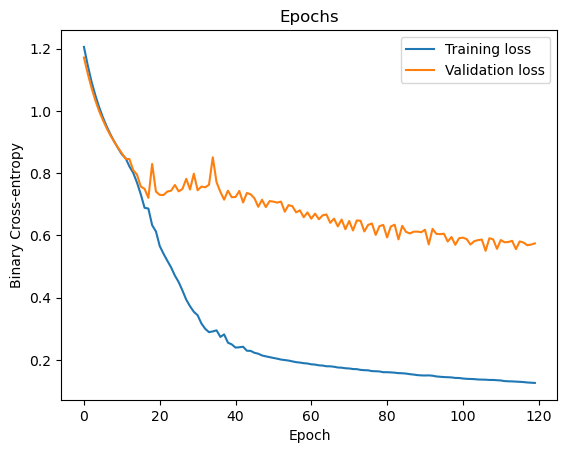

In [19]:
# epoch = np.arange(len(losses))/n_blocks
plt.plot(losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title("Epochs")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-entropy")

## Exercise 7 - How good is your model? 🤑🤑🤑

Evaluate the ability of your model to discriminate nuclear from electron recoils. 
There are several ways to convince ourselves that the model we trained and discussions may take for ever. 
For the sake of the school, it suggested you limit yourself to a couple of quick checks. For example:

#### Plot the histogram of the DNN response 📊
Plot in a histogram the response of the classifier (a.k.a. the estimated probability of being an 
event due to a nuclear recoil) as obtained on events of the training and validation sample. 

You should be able to reach a rather good separation between the two hypotheses as shown in the 
figure below.

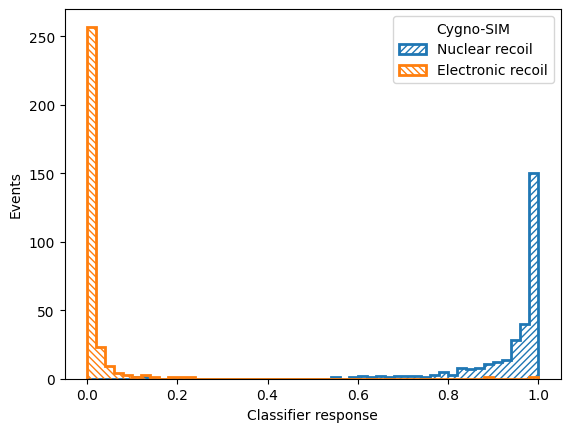


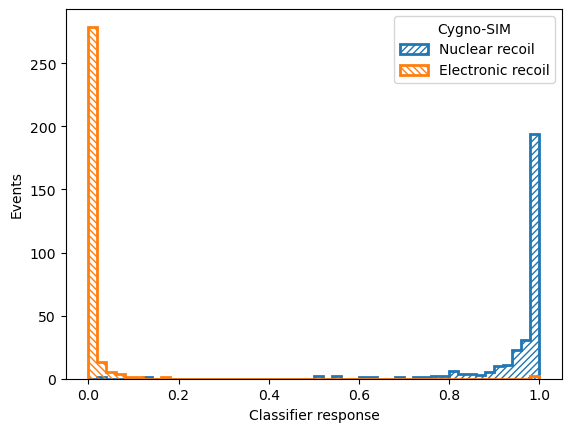

In [20]:
predictions = np.concatenate([classifier(tf.constant(X)) for X in list(X_train.blocks) + list(X_valid.blocks)])
labels = dask.array.concatenate([y_train, y_valid]).compute()
plt.hist(predictions[labels>0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='/'*5, linewidth=2, label="Nuclear recoil")
plt.hist(predictions[labels<0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='\\'*5, linewidth=2, label="Electronic recoil")
plt.legend(title="Cygno-SIM")
plt.xlabel("Classifier response")
plt.ylabel("Events")
plt.show()

#### Draw the ROC curve 📉

The [Reciever operating Characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  is often used to represent the performance at various regimes of a binary classification algorithm. It is obtained by scanning the threshold on the classifier response and measuring the signal efficiency and background rejection for each scanned threshold.

Putting in a graph these points one gets a curve that may resemble to the following one.

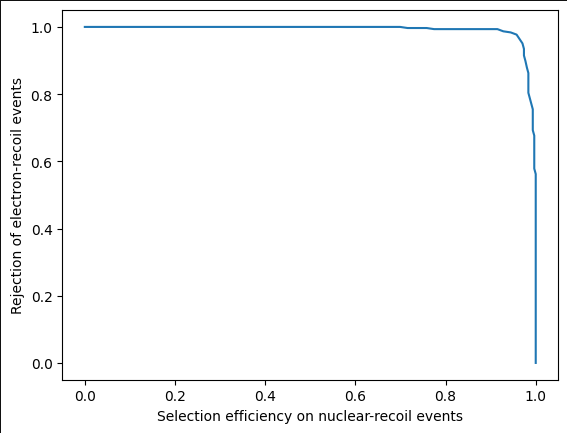

The closer to (1, 1), the better the algorithm performs!

> **Caveats!** 🧐 We are simplifying things a little bit. First of all, we have checked only very roughly that the model is not overfitting too much, so measuring the performance with the training dataset is not rock solid. In addition, we might have tuned the hyperparameters of our model at the point it generalizes to the validation set (and so we are convinced it is not overtrained), but it does not generalize to a third, statistically equivalent, dataset. To do things properly, you should use a third dataset, never used for training only to *measure the performance* of your model. 

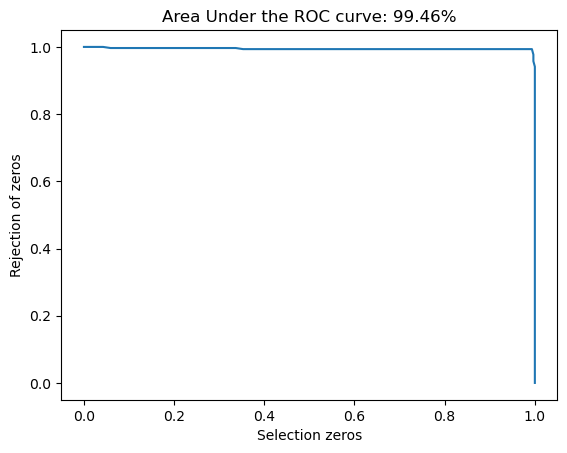

In [21]:
## We pick some meaningful threshold values, by using the quantile function of numpy
thresholds = np.quantile(predictions, np.linspace(0, 1, 101))

## We select the predictions associated to non-zero pictures by the ground-truth label.
non_zeros_y = predictions[labels>0.5]

## For each threshold, we count the fraction of non-zero picutres above that threshold
## This represents the "selection efficiency" of non-zero candidates.
non_zero_efficiency = np.array([np.count_nonzero(non_zeros_y > t) for t in thresholds])/len(non_zeros_y)


## Same thing for the zero picture. First we select them by cutting on the ground-truth.
zeros_y = predictions[labels<0.5]
## Then we comute the rejection (1-selection efficiency)
zeros_rejection = np.array([np.count_nonzero(zeros_y < t) for t in thresholds])/len(zeros_y)

## Finally we use the trapz function of numpy to compute the integral of the ROC curve
roc_auc = np.trapz(non_zero_efficiency, zeros_rejection)

## ..cosmetics...
plt.title (f"Area Under the ROC curve: {roc_auc*100.:.2f}%")
plt.plot(non_zero_efficiency, zeros_rejection)
plt.xlabel("Selection zeros")
plt.ylabel("Rejection of zeros")
plt.show()

#### Bonus: Visualize the performance in bins of the energy <BIG>🏃‍♀️</BIG>

> **Bonus!** This validation is not required for any successive step of the exercise. You are advised not to waste time on it if you feel in a hurry.

The ability of the model to distinguish the type of recoil may depend on the energy of the collision.
Since the energy used to simulate the event is known, you may want to repeat the visualization exercise above in intervals of the energy, for example 
below 5 keV, between 5 and 15 keV and above 15 keV.

For example, you may obtain something on the line of the following figure
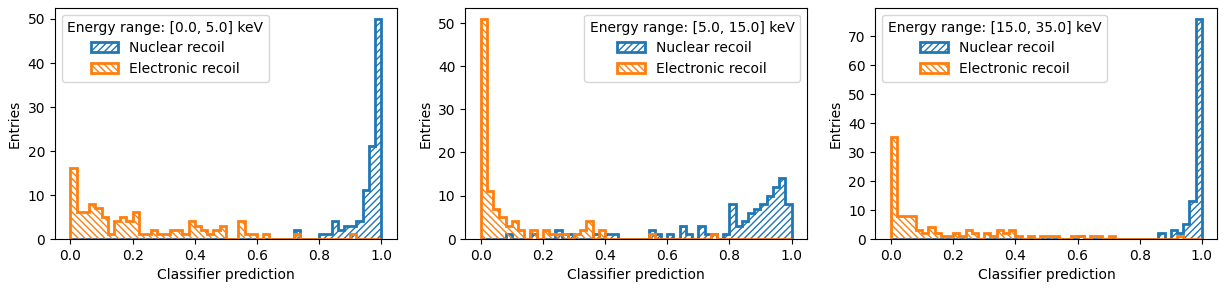

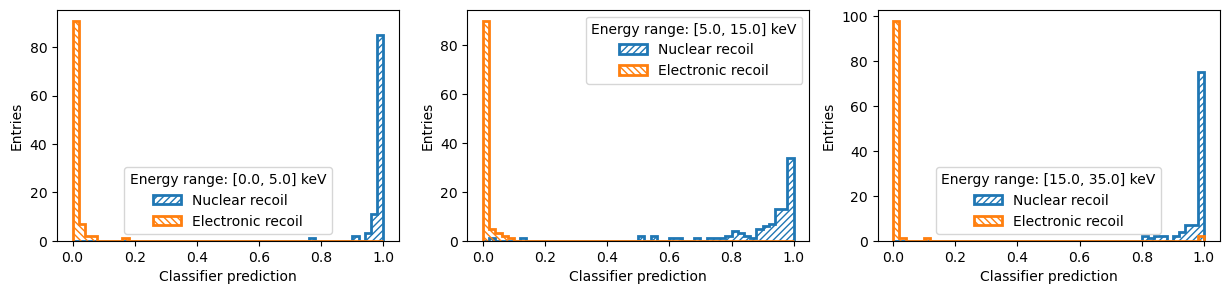

In [22]:
energy_boundaries = 0, 5, 15, 35

predictions = np.concatenate([classifier(tf.constant(X)) for X in list(X_train.blocks) + list(X_valid.blocks)])
labels = dask.array.concatenate([y_train, y_valid]).compute()
energy = dask.array.concatenate([training_energy, validation_energy]).compute()


plt.figure(figsize=(15,3))
for iPlot, (e_min, e_max) in enumerate(zip(energy_boundaries[:-1], energy_boundaries[1:]), 1):
    plt.subplot(1, 3, iPlot)
    plt.hist(predictions[(labels>0.5) & (energy > e_min) & (energy < e_max)], bins=np.linspace(0, 1, 51), histtype='step', hatch='/'*5, linewidth=2, label="Nuclear recoil")
    plt.hist(predictions[(labels<0.5) & (energy > e_min) & (energy < e_max)], bins=np.linspace(0, 1, 51), histtype='step', hatch='\\'*5, linewidth=2, label="Electronic recoil")
    plt.legend(title=f"Energy range: [{e_min:.1f}, {e_max:.1f}] keV")
    plt.xlabel("Classifier prediction")
    plt.ylabel("Entries")
plt.show()


## 🃏 Exercise 8 - Create a Regression model 🔮

>  The 🃏 indicates a bonus track, not strictly needed to complete the project. Feel free to skip and come back later.

If we want to investigate effects related to the energy in acquired data, it might be a good idea to develop some technique to obtain an estimate for the energy of the collision directly from the acquired image. 

Indeed, while for simualated data the information on the collision energy is given, we have no hint on the energy of a real-data collision beyond what we can say from the acquired image itself.

Technically, this is a ***regression task***. You can train a Convolutional Neural Network to predict the value of the energy using the simulation and then employ it in real data as a **reconstruction algorithm**.

Tweak you classifier NN as defined above to face a regression task. Remember:
 * The overall structure, obtained for classification, is most likely ok also for regression
 * The output layer should now return an energy (a sigmoid activation might be less appropriate)
 * Using a Binary Crossentropy, is **definitely** less appropriate. Hoepfully you can pick another loss from the [`keras.losses` module](https://keras.io/api/losses/)

## 🃏 Exercise 9 - Preprocess the energy and re-chunk your dask arrays to represent batches

As you did before for the classification task, you will need to create dask arrays with the right chunk structure for your training and validation sets. 

The target of your algorithm won't be the classification label this time, but rather the energy of the collision 💥! 


As discussed above, training neural networks is much easier if one can count on features of $\mathcal O (1)$. 

Now, the energies in this exercise, expressed in keV, are not too far from $\mathcal O(1)$ so there are chances you can succeed training your network without any preprocessing.

Still, dividing the energy by $30$ keV while rechunking it may make the training faster and it takes literally less than 10 key strokes.


In [23]:
batch_size = 10

X_train = training_set.rechunk( [batch_size, None, None] )
X_valid = validation_set.rechunk( [-1, None, None] )
y_train = (training_energy/30).rechunk(batch_size)
y_valid = (validation_energy/30).rechunk(batch_size)

## 🃏 Exercise 10 - Train the regression model for 50 epochs (🏋️$\times 50$)

The same code snippet developed above for training the classifier on 50 epochs should work here for your regressor, but **don't forget to change your input variables!**

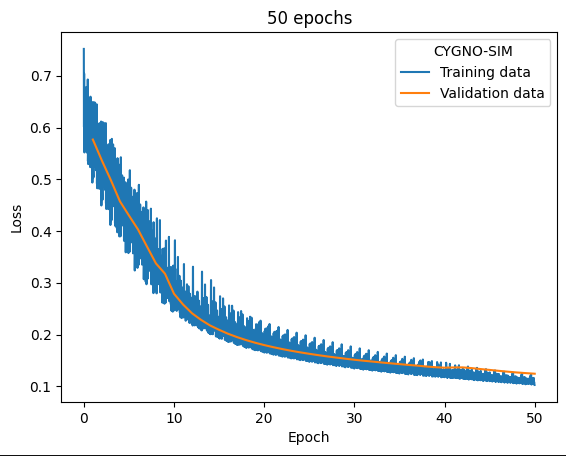


## 🃏 Exercise 11 - Displaying the performance of your regressor

To validate the classifier neural network we studied the distribution of the response of the neural network for the various classes. 
Here we don't really have classes, but rather a continuos value (the energy) that the neural network should try to guess. 

An option to visualize the quality of the model is to create a scatter plot comparing the predicted value to the *ground-truth*, the energy used during the training. For the ideal regressor, such plot would be a set of points laying on the bisector line, for real regressors the distribution will widen, but will around the bisector line. So the thinner the distribution the better the regressor.

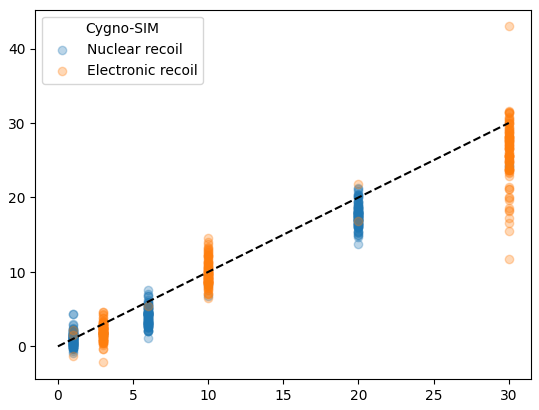

## Exercise 12 - Deploy 🪁

Well done! Now you are ready to use your model to process the events submitted from the DAQ system we have discussed on Day 2.


### Ex. 12.1 - Store the models to files

To push the model in a pipeline, you don't want to have it running in interactive mode (though we all love notebooks) so, as a very first thing, you need to export the model from this notebook and make it available to other applications, possibly without direct access to your filesystem 👉 upload it on Minio.

To store a model you can use [the function `keras.models.Model.save`](https://keras.io/api/saving/model_saving_and_loading/#save-method).

For example,
```python
import tensorflow as tf

my_model = tf.keras.models.Sequential()
# ... define the layers

## Train your model
my_model.fit(...)

## Validate your model
my_model.predict(...)

## And finally, store your model in a local file
my_model.save("my_model.keras")
```




In [24]:
classifier.save("myclassifier_cnn.keras")

Then upload the model(s) stored locally to Minio by using the s3 protocol and the Minio SDK.

## ... TO BE CONTINUED ...

The exercise continues in a [separated notebook](./3-Project-Day3-deploy.ipynb) dedicated to deployment.